In [380]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import datetime as dt

from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB

from sklearn import metrics
from sklearn import preprocessing
import keras
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import datetime as dt
%matplotlib inline


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, History
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.optimizers import SGD, Adam

from sklearn.model_selection import GridSearchCV

# Problem Overview

In this data challenge, I will use Airbnb data to predict whether a user will request a booking or not 30 days into the future. The dataset provided here contains a random sample of listings from three markets, San Francisco, Paris and Los Angeles.

(Note: This paragraph is direclty from Prompt) Each row in the dataset is a combination of a listing and a calendar night for which we try to predict if it will be booked, based on what we know 30 days prior to the calendar night.The calendar night is denotedby ds_night and ranges between 2015-01-01 and 2015-12-31. All the data in the dataset, except for column dim_is_requested, is current for 30 days beforeds_night, denoted by ds (i.e., ds + 30 days = ds_night).

`dim_is_requested` refers to whether or not the listing was ultimately requested a booking for theds_night. Listing, ds_night combinations that were already booked or are otherwise unavailable 30 days prior willnot appear in the dataset.

This notebook is brokwn down into the following components:

    PART A - Data Preprocessing
    PART B - Train, Validation and Test Splitting
    PART C- Baseline Creation
    PART D - Model Training and Tuning 
    PART E - Feature Engineering
    PART F - Advanced Algorithmic Improvements
    PART G - Evaluation on Test Data
    PART H - Conclusion and Product Recommendations

# Reading Data
Let's start by reading the data and looking at some quick statistics to get a sense of the volume and magnitude of the data we are dealing with. From the data we can see that there are a few kinds of features:

1) Price: price of listing on a given night

2) Listing attributes:  such as exact location, size,reviews, decor, etc;

3) Occupancy and availability of the listing: these features are calculated looking at the status of the calendar.

4) Demand for alisting: based on clicks and views

5) Demand and supply within a KDT-Room type cluster: from a machine learning algorithm to cluster the listings that are close geographically, as an automated way to identify neighborhoods.gs.

In [411]:
airbnb_data = pd.read_csv('TH_data_challenge.tsv', sep='\t')
airbnb_data.head()

,dim_is_requested,ds_night,ds,id_listing_anon,id_user_anon,m_effective_daily_price,m_pricing_cleaning_fee,dim_market,dim_lat,dim_lng,dim_room_type,dim_person_capacity,dim_is_instant_bookable,m_checkouts,m_reviews,days_since_last_booking,cancel_policy,image_quality_score,m_total_overall_rating,m_professional_pictures,dim_has_wireless_internet,ds_night_day_of_week,ds_night_day_of_year,ds_checkin_gap,ds_checkout_gap,occ_occupancy_plus_minus_7_ds_night,occ_occupancy_plus_minus_14_ds_night,occ_occupancy_trailing_90_ds,m_minimum_nights,m_maximum_nights,price_booked_most_recent,p2_p3_click_through_score,p3_inquiry_score,listing_m_listing_views_2_6_ds_night_decay,general_market_m_unique_searchers_0_6_ds_night,general_market_m_contacts_0_6_ds_night,general_market_m_reservation_requests_0_6_ds_night,general_market_m_is_booked_0_6_ds_night,m_available_listings_ds_night,kdt_score,r_kdt_listing_views_0_6_avg_n100,r_kdt_n_active_n100,r_kdt_n_available_n100,r_kdt_m_effective_daily_price_n100_p50,r_kdt_m_effective_daily_price_available_n100_p50,r_kdt_m_effective_daily_price_booked_n100_p50
0,False,2015-01-06,2014-12-07,0ae0c7cc-a8a4-425f-9ccc-8b25dbb94f4d,dcc74708-d5c4-47b2-bc0c-97bf5abfcd99,110.000000,60.0,Los Angeles,34.053932,-118.362970,Private room,2,False,24.0,19.0,320.0,4,0.830959,74.0,16.0,1,2,6,0.0,7.0,NaN,NaN,0.000000,5.0,90.0,92.0,NaN,NaN,0.133333,788.142857,241.428571,41.428571,1.0,9840,1.314286,1.795918,57.0,48.0,79.0,75.0,98.0
1,True,2015-01-21,2014-12-22,82fdda07-6993-4cca-8ee4-fc218d2c07c7,559d8981-0c75-4631-9582-a3b644bb5631,70.000000,0.0,Los Angeles,34.108578,-118.208600,Private room,2,True,105.0,55.0,3.0,3,0.967384,263.0,0.0,1,3,21,7.0,7.0,NaN,NaN,0.359551,1.0,1125.0,70.0,NaN,NaN,0.066667,830.142857,298.000000,51.714286,1.0,9599,0.535714,2.693878,49.0,36.0,65.0,65.0,42.0
2,False,2015-01-22,2014-12-23,69b2069d-cf8f-49a7-b559-9619dbe86a7d,ee7901a6-79d5-4d69-bacf-e4bca976a66a,125.000000,0.0,Los Angeles,34.077194,-118.205700,Private room,1,False,0.0,0.0,NaN,3,0.485231,0.0,0.0,1,4,22,7.0,7.0,NaN,NaN,0.000000,1.0,1125.0,NaN,NaN,NaN,0.000000,810.142857,281.000000,51.714286,1.0,9514,0.714286,2.775510,49.0,35.0,65.0,66.5,46.0
3,True,2015-02-02,2015-01-03,66baade6-9352-4d7c-b590-745899bd12b3,af691f3d-525e-497c-b9c5-8750b097b04d,126.866667,125.0,Los Angeles,34.093494,-118.247340,Entire home/apt,6,False,0.0,0.0,NaN,5,0.309310,0.0,0.0,1,1,33,7.0,7.0,0.0,0.0,0.000000,3.0,1125.0,NaN,NaN,NaN,0.733333,816.857143,274.428571,41.857143,1.0,9739,1.744681,4.576531,113.0,52.0,120.0,115.0,115.0
4,True,2015-02-13,2015-01-14,01e3589e-a50a-494b-8cb2-9645b29476d0,6733a1d9-d485-4ea7-b8d2-883ee8a363b9,210.714286,200.0,Los Angeles,34.097540,-118.363556,Entire home/apt,5,False,9.0,1.0,34.0,5,0.335816,5.0,0.0,1,5,44,7.0,7.0,0.0,0.0,0.133333,2.0,1125.0,296.0,NaN,NaN,1.000000,1347.428571,419.428571,78.857143,1.0,9114,1.200000,4.877551,97.0,57.0,150.0,157.5,164.5


In [412]:
print('The number of rows are: ' + str(airbnb_data.shape[0]))
print('The number of columns are: ' + str(airbnb_data.shape[1]))
print('The number of unique listings are: ' + str(airbnb_data['id_listing_anon'].nunique()))
print('The number of unique users are: ' + str(airbnb_data['id_user_anon'].nunique()))
print('The number of calendar days in the data are: ' + str(airbnb_data['ds_night'].nunique()))

The number of rows are: 184279
The number of columns are: 46
The number of unique listings are: 10442
The number of unique users are: 7936
The number of calendar days in the data are: 364


The distribution of the predicted feature (whether a listing will be booked or not on a given day 30 days in the future is shown below. From the distribution, it can be seen that the 2 classes Not Booked vs Booked are distributed approximately 66% vs 33% with 33% of listings ending up booked on a given day 30 days into the future (Flagged as 1).

AxesSubplot(0.125,0.125;0.775x0.755)


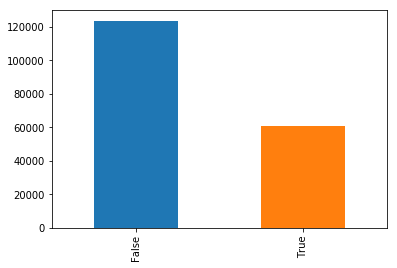

In [413]:
print(airbnb_data['dim_is_requested'].value_counts().plot('bar'))
airbnb_data['dim_is_requested'] = airbnb_data['dim_is_requested'].astype('int64')

Looking at the distribution of the predictor features below we can see that almost all features are on different scales and have very different distributions. This means I will be doing scaling before training models.

In [414]:
airbnb_data.describe()

,dim_is_requested,m_effective_daily_price,m_pricing_cleaning_fee,dim_lat,dim_lng,dim_person_capacity,m_checkouts,m_reviews,days_since_last_booking,cancel_policy,image_quality_score,m_total_overall_rating,m_professional_pictures,dim_has_wireless_internet,ds_night_day_of_week,ds_night_day_of_year,ds_checkin_gap,ds_checkout_gap,occ_occupancy_plus_minus_7_ds_night,occ_occupancy_plus_minus_14_ds_night,occ_occupancy_trailing_90_ds,m_minimum_nights,m_maximum_nights,price_booked_most_recent,p2_p3_click_through_score,p3_inquiry_score,listing_m_listing_views_2_6_ds_night_decay,general_market_m_unique_searchers_0_6_ds_night,general_market_m_contacts_0_6_ds_night,general_market_m_reservation_requests_0_6_ds_night,general_market_m_is_booked_0_6_ds_night,m_available_listings_ds_night,kdt_score,r_kdt_listing_views_0_6_avg_n100,r_kdt_n_active_n100,r_kdt_n_available_n100,r_kdt_m_effective_daily_price_n100_p50,r_kdt_m_effective_daily_price_available_n100_p50,r_kdt_m_effective_daily_price_booked_n100_p50
count,184279.000000,184279.000000,184279.000000,184279.000000,184279.000000,184279.000000,184092.000000,184092.000000,146443.000000,184279.000000,170268.000000,184092.000000,184092.000000,184279.000000,184279.000000,184279.000000,182058.000000,182058.000000,163552.000000,163627.000000,174061.000000,182058.000000,1.820580e+05,146443.000000,57169.000000,54989.000000,181933.000000,184279.000000,184279.000000,184279.000000,184279.000000,184279.000000,184279.000000,184278.000000,184278.000000,184278.000000,184278.000000,184262.000000,171304.000000
mean,0.328361,149.405456,38.014286,43.551959,-44.277191,3.265234,18.461883,10.971194,69.174136,4.154109,0.562056,47.881706,4.795211,0.937741,2.998763,174.657953,5.888091,6.123241,0.061373,0.079742,0.280268,4.998753,4.782557e+04,140.255458,0.231738,0.180926,0.385088,1702.574448,507.456627,91.624327,0.973079,18551.170611,1.067703,2.098260,90.208587,45.636869,109.231766,115.385867,95.601191
std,0.469618,272.233310,49.998184,6.817239,59.187486,2.009478,32.309469,20.020473,123.530963,0.816571,0.306840,86.908863,8.503853,0.241626,2.004867,108.087953,2.197909,2.041068,0.159816,0.171301,0.311951,22.389882,1.006587e+07,159.847870,0.073645,0.073416,1.032900,686.574394,255.179472,48.652866,0.071519,9099.781958,0.523330,2.081157,75.792493,37.506994,64.013523,72.728042,48.744252
min,0.000000,-55.000000,0.000000,33.708763,-122.510925,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000e+00,0.000000,0.052968,0.013492,0.000000,316.714286,52.000000,13.142857,0.571429,1028.000000,-1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,71.349427,0.000000,34.129663,-118.357056,2.000000,1.000000,0.000000,5.000000,3.000000,0.300549,0.000000,0.000000,1.000000,1.000000,77.000000,7.000000,7.000000,0.000000,0.000000,0.000000,1.000000,3.000000e+01,69.000000,0.181564,0.128333,0.000000,1194.285714,349.714286,56.000000,1.000000,9690.000000,0.666667,0.857143,48.000000,25.000000,75.000000,77.728465,65.000000
50%,0.000000,100.000000,25.000000,48.844982,2.303334,2.000000,6.000000,3.000000,20.000000,4.000000,0.577958,14.000000,0.000000,1.000000,3.000000,171.000000,7.000000,7.000000,0.000000,0.000000,0.148148,2.000000,1.125000e+03,100.000000,0.223077,0.171852,0.000000,1629.857143,488.000000,83.142857,1.000000,21027.000000,1.037037,1.632653,86.000000,41.000000,95.259429,98.538890,86.079324
75%,1.000000,152.346733,53.947735,48.871037,2.355681,4.000000,22.000000,12.000000,72.000000,5.000000,0.853520,54.000000,10.000000,1.000000,5.000000,267.000000,7.000000,7.000000,0.000000,0.068966,0.530612,3.000000,1.125000e+03,155.000000,0.270523,0.223158,0.333333,2175.428571,619.285714,116.714286,1.000000,24867.000000,1.396552,2.717687,113.000000,56.000000,129.000000,135.474918,115.754137
max,1.000000,12995.000000,800.000000,49.187890,2.887966,16.000000,432.000000,280.000000,1041.000000,8.000000,0.999996,1313.000000,80.000000,1.00

Now let's sort the data by listing id and dates to see if there are any gaps in the data. From the sorted data below we can see that there are indeed some dates for which there is no data for a listing date combination. From the prompt we know that listing, ds_night combinations that were already booked or are otherwise unavailable 30 days prior will not appear in the dataset. Therefore, we can assume that these days are missing because of either of the two reasons. We will use this implicit knowledge to also derive features later on.

In [415]:
airbnb_data = airbnb_data.sort_values(by=['id_listing_anon', 'ds_night'])
airbnb_data.head(5)

,dim_is_requested,ds_night,ds,id_listing_anon,id_user_anon,m_effective_daily_price,m_pricing_cleaning_fee,dim_market,dim_lat,dim_lng,dim_room_type,dim_person_capacity,dim_is_instant_bookable,m_checkouts,m_reviews,days_since_last_booking,cancel_policy,image_quality_score,m_total_overall_rating,m_professional_pictures,dim_has_wireless_internet,ds_night_day_of_week,ds_night_day_of_year,ds_checkin_gap,ds_checkout_gap,occ_occupancy_plus_minus_7_ds_night,occ_occupancy_plus_minus_14_ds_night,occ_occupancy_trailing_90_ds,m_minimum_nights,m_maximum_nights,price_booked_most_recent,p2_p3_click_through_score,p3_inquiry_score,listing_m_listing_views_2_6_ds_night_decay,general_market_m_unique_searchers_0_6_ds_night,general_market_m_contacts_0_6_ds_night,general_market_m_reservation_requests_0_6_ds_night,general_market_m_is_booked_0_6_ds_night,m_available_listings_ds_night,kdt_score,r_kdt_listing_views_0_6_avg_n100,r_kdt_n_active_n100,r_kdt_n_available_n100,r_kdt_m_effective_daily_price_n100_p50,r_kdt_m_effective_daily_price_available_n100_p50,r_kdt_m_effective_daily_price_booked_n100_p50
92617,0,2015-01-03,2014-12-04,00004783-f5e1-47cf-90bf-3daad76d1a09,251917ad-d2e8-467d-ace3-7e5699e16b89,308.737257,85.950775,Paris,48.87363,2.312445,Entire home/apt,3,False,0.0,0.0,NaN,3,0.095232,0.0,0.0,1,6,3,7.0,7.0,NaN,NaN,0.0,1.0,1125.0,NaN,NaN,NaN,0.000000,1673.857143,782.571429,144.142857,1.0,19373,0.863636,3.532653,124.0,61.0,166.718119,194.504472,135.844393
45319,0,2015-01-04,2014-12-05,00004783-f5e1-47cf-90bf-3daad76d1a09,251917ad-d2e8-467d-ace3-7e5699e16b89,308.386883,85.809113,Paris,48.87363,2.312445,Entire home/apt,3,False,0.0,0.0,NaN,3,0.095232,0.0,0.0,1,0,4,7.0,7.0,NaN,NaN,0.0,1.0,1125.0,NaN,NaN,NaN,0.000000,1288.428571,563.000000,102.714286,1.0,19654,0.727273,2.262585,123.0,61.0,160.361179,185.032130,132.606360
4394,0,2015-01-07,2014-12-08,00004783-f5e1-47cf-90bf-3daad76d1a09,251917ad-d2e8-467d-ace3-7e5699e16b89,307.170580,85.542191,Paris,48.87363,2.312445,Entire home/apt,3,False,0.0,0.0,NaN,3,0.095232,0.0,0.0,1,3,7,7.0,7.0,NaN,NaN,0.0,1.0,1125.0,NaN,NaN,NaN,0.733333,1162.428571,440.285714,76.428571,1.0,20774,0.863636,1.938776,122.0,66.0,159.728702,165.872113,135.155055
177135,0,2015-01-13,2014-12-14,00004783-f5e1-47cf-90bf-3daad76d1a09,251917ad-d2e8-467d-ace3-7e5699e16b89,311.518725,85.266556,Paris,48.87363,2.312445,Entire home/apt,3,False,0.0,0.0,NaN,3,0.095232,0.0,0.0,1,2,13,7.0,7.0,NaN,NaN,0.0,1.0,1125.0,NaN,NaN,NaN,0.000000,1104.714286,418.142857,62.571429,1.0,21457,0.454545,2.367347,122.0,72.0,160.743662,186.911235,111.523704
43123,0,2015-01-14,2014-12-15,00004783-f5e1-47cf-90bf-3daad76d1a09,251917ad-d2e8-467d-ace3-7e5699e16b89,311.522589,85.177414,Paris,48.87363,2.312445,Entire home/apt,3,False,0.0,0.0,NaN,3,0.095232,0.0,0.0,1,3,14,7.0,7.0,NaN,NaN,0.0,1.0,1125.0,NaN,NaN,NaN,0.000000,1118.285714,419.285714,62.000000,1.0,21513,0.727273,2.151020,123.0,73.0,158.253475,171.337424,112.148132


# PART A - Data Preprocessing
## a) Handling Missing Values 
Before I can start training my model, I have to process the data so that it can be fed into a machine learning algorithm. Let's check to see which features have missing data.

Important Note: Some algorithms like Linear Regression can be very sensitive to outliers in the data. Other algos like Tree Methods (and Log Regression) are not sensitive to large outliers but for Linear Regressions it can make a difference in performance. Since this is a binary classification problem and linear regression will not be used I will skip capping outliers as it's unlikely to lead to a big change in performance here.

In [416]:
print('Lets check for missing values in the data')
print()
print('feature_name, number of nulls')
for feature in airbnb_data.columns:
    print(str(feature) + ',' + str(sum(pd.isnull(airbnb_data[feature]))))

Lets check for missing values in the data

feature_name, number of nulls
dim_is_requested,0
ds_night,0
ds,0
id_listing_anon,0
id_user_anon,0
m_effective_daily_price,0
m_pricing_cleaning_fee,0
dim_market,0
dim_lat,0
dim_lng,0
dim_room_type,0
dim_person_capacity,0
dim_is_instant_bookable,0
m_checkouts,187
m_reviews,187
days_since_last_booking,37836
cancel_policy,0
image_quality_score,14011
m_total_overall_rating,187
m_professional_pictures,187
dim_has_wireless_internet,0
ds_night_day_of_week,0
ds_night_day_of_year,0
ds_checkin_gap,2221
ds_checkout_gap,2221
occ_occupancy_plus_minus_7_ds_night,20727
occ_occupancy_plus_minus_14_ds_night,20652
occ_occupancy_trailing_90_ds,10218
m_minimum_nights,2221
m_maximum_nights,2221
price_booked_most_recent,37836
p2_p3_click_through_score,127110
p3_inquiry_score,129290
listing_m_listing_views_2_6_ds_night_decay,2346
general_market_m_unique_searchers_0_6_ds_night,0
general_market_m_contacts_0_6_ds_night,0
general_market_m_reservation_requests_0_6_ds_nigh

We can see that a lot of features have null values. Some of these make a lot of sense if a listing never had a booking in the past. For example, "days_since_last_booking" will be null for listings with no bookings in the past. Similarly if a listing just launched, we might not have data going back 7 or 14 days so features like occ_occupancy_plus_minus_14_ds_night will not have any data.

For these features which make intuitive sense we can just hardcode missing values to a unique number never seen before (example: -1). For other features like "m_checkouts", and "m_reviews", since the number of missing rows is so small (187 records). we can just drop them from the dataset as 187 rows is unlikely to make a big difference in performance.

Finally some other features like 'image quality score' and 'p2_p3_click_through_score' seem to be missing values for some users. We could use the mean value for the KDT node for these values to replace the missing values with. (Note: The key assumption being here that these features are fairly "static" features in nature so taking a mean across the entire dataset won't result in any leakage from the future.). Although for now we will just hard code to unseen -1 value for missing data.

Because of time constraints, the missing values are being imputed. However if I had more time (and data) I would actually build separate predictive models to predict the missing values (for example: predict click through score).

## b) Checking distributions of Some Features with Missing Data

Also, double checking to see if there is anything else that is funky about these features that have a lot of missing data. Most seem to have a healthy distribution count so we can try to assume that the missing values are not necessarily due to complete garbage data.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1ebfe9c88>]],
      dtype=object)

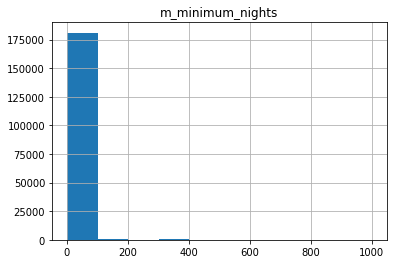

In [417]:
airbnb_data.hist('m_minimum_nights')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x22d8a4208>]],
      dtype=object)

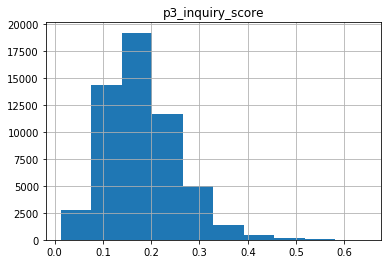

In [418]:
airbnb_data.hist('p3_inquiry_score')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x231140b70>]],
      dtype=object)

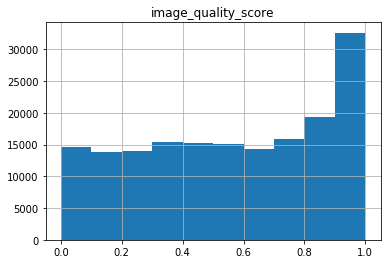

In [419]:
airbnb_data.hist('image_quality_score', bins =10)

In [420]:
def clean_data(data):
    
    data['days_since_last_booking'] = data['days_since_last_booking'].fillna(-1)
    data['occ_occupancy_plus_minus_7_ds_night'] = data['occ_occupancy_plus_minus_7_ds_night'].fillna(-1)
    data['occ_occupancy_plus_minus_14_ds_night'] = data['occ_occupancy_plus_minus_14_ds_night'].fillna(-1)
    data['occ_occupancy_trailing_90_ds'] = data['occ_occupancy_trailing_90_ds'].fillna(-1)
    
    data['m_minimum_nights'] = data['m_minimum_nights'].fillna(-1)
    data['m_maximum_nights'] = data['m_maximum_nights'].fillna(-1)
    data['ds_checkin_gap'] = data['ds_checkin_gap'].fillna(0)
    data['ds_checkout_gap'] = data['ds_checkout_gap'].fillna(0)
    data['price_booked_most_recent'] = data['price_booked_most_recent'].fillna(-1)
    
    data['listing_m_listing_views_2_6_ds_night_decay'] = data['listing_m_listing_views_2_6_ds_night_decay'].fillna(0)
    
    data['p2_p3_click_through_score'] = data['p2_p3_click_through_score'].fillna(-1)
    data['p3_inquiry_score'] = data['p3_inquiry_score'].fillna(-1)
    data['r_kdt_m_effective_daily_price_booked_n100_p50'] = data['p3_inquiry_score'].fillna(-1)
    
    data['image_quality_score'] = data['image_quality_score'].fillna(-1)

    data.dropna(axis=0,inplace=True)
    return data
 
airbnb_data = clean_data(airbnb_data)

Using the above function , it now looks like the missing values are all gone and our data should have been cleaned!

## c) Converting Categorical Features to Dummy Variables
Most of the features are numeric in this dataset but a couple are categorical (dim_is_instant_bookable, dim_market, dim_room_type). These will be one hot encoded to a binary category for each class so they can be fed into the algorithm

In [421]:
# Convert categorical features to dummy variables using one hot encoding
airbnb_data['dim_is_instant_bookable'] = airbnb_data['dim_is_instant_bookable'].astype('int64')
categorical_columns = ['dim_market','dim_room_type']
one_hot_encoded_columns = pd.get_dummies(airbnb_data[categorical_columns], drop_first=True)
airbnb_data = pd.concat([airbnb_data, one_hot_encoded_columns], axis =1)
columns_to_drop = ['dim_market', 'dim_room_type']
airbnb_data.drop(columns = columns_to_drop, inplace=True)

# PART B - Train, Validation and Test Splitting

Now that we have cleaned the data, the next step is to create train, validation and test splits which can be used to train and evaluate the models we will build. Since the data is time series centric with an element of seasonality, and we only have a full year's worth of data the cutoff for train and test will be done randomly. By doing a random split we ensure both train and test have some component from each week of the year so they can fully understand seasonality in bookings. 

Second, looking at the time distribution of records below we can see that there is a peak early on in December (as expected because of the holidays) but otherwise each month has a reasonable amount of records so we do not risk missing some time periods if we random sampled.

However, if we had more than year's worth of data (let's say 2 whole years), then it might be better to split train and test by year. For example train in 2016 and test in 2017. This helps in generalizing and preventing overfitting to highly local and unique trends that might occur one year but not the other. (Example: Let's say there is a once in a lifetime concert in New York that only occured in June 2017 and led to a surge in bookings for that month year only)

Test was split in a 30% ratio. The remaining 70% were further split in a 70/30% ratio into train and validation. So approiximately 50% of the data was train. 20% was validation. 30% was Test.

All features were also normalized using mean-std scaling

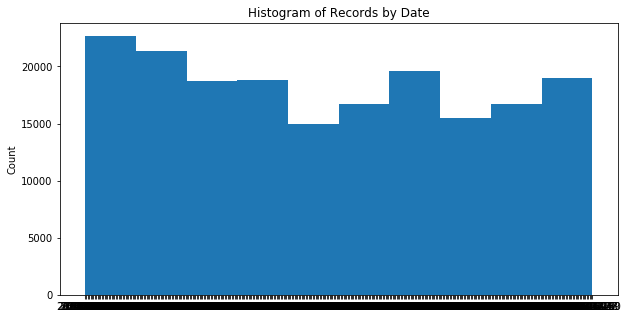

In [431]:
fig, ax = plt.subplots(figsize=(10,5))
plt.hist((airbnb_data['ds']))
ax.set_ylabel('Count')
ax.set_title("Histogram of Records by Date")
plt.show()

In [423]:
def train_valid_test_split(data, split_perc):
    
    #train_valid = data[data['ds'] <= date_cutoff]
    #test = data[data['ds'] > date_cutoff] 
    np.random.seed(1267868)
    
    standard_scaler = preprocessing.StandardScaler(with_mean=True, with_std=True)
    
    train_valid, test = train_test_split(data, test_size=split_perc, random_state = 45)
    train, valid = train_test_split(train_valid, test_size=split_perc, random_state = 45)
    
    x_train = train.iloc[:,5:]
    x_valid = valid.iloc[:,5:]
    x_test = test.iloc[:,5:]
    
    x_train = standard_scaler.fit_transform(x_train)
    x_valid = standard_scaler.fit_transform(x_valid)
    x_test = standard_scaler.fit_transform(x_test)
    
    y_train = train.loc[:,'dim_is_requested']
    y_valid = valid.loc[:,'dim_is_requested']
    y_test = test.loc[:,'dim_is_requested']
        
    return x_train, x_valid, x_test, y_train, y_valid, y_test

x_train, x_valid, x_test, y_train, y_valid, y_test = train_valid_test_split(airbnb_data, 0.3)

In [424]:
print('The number of records and columns in train are: ' + str(x_train.shape))
print('The number of records and columns in validation are: ' + str(x_valid.shape))
print('The number of records and columns in test are: ' + str(x_test.shape))

The number of records and columns in train are: (90196, 43)
The number of records and columns in validation are: (38656, 43)
The number of records and columns in test are: (55223, 43)


# PART C -   Baseline Creation
For the baseline, we will simply take the booking status of the last period for which we have data for that listing prior to the'ds' or the calendar date. So for example if the ds = '2014-12-15' and we are predicting for '2015-01-14' then the baseline will take the last bookings status of the period prior to '2015-12-15'. 

For example, if there is data for '2015-12-14' then we will use the booking status for that day as our prediction for ds = '2015-12-15'. If not, then we will keep going back until there is data for that listing from a date. For days for which we do not have any prior historical data, we simply predict 0.

In [396]:
#baseline_prob = bookings_last_day(airbnb_data['dim_is_requested'], 1) 
baseline_prob = airbnb_data.groupby('id_listing_anon')['dim_is_requested'].apply(lambda x: x.shift(1))
baseline_prob = baseline_prob.fillna(0)

## Selection of Evaluation Metric

Now that we have a baseline, we need to decide on how to evaluate the performance of different models or approaches. Since this is a binary classification problem it makes most sense to use either Accuracy (percentage of predictions that were classified correctly into both positive and negative classes) or AUC (area under curve) for evaluation. 

Accuracy is a good measure because it is intuitive from a business perspective but is useless when classes are extremely imbalanced. However, in this data classes are not imbalanced completely. A 66% ratio ensures that accuracy won't be 'gamed' by just predicting the majority class.

For this reason the primary metric for evaluation will be Accuracy. However, I will also look at Precision and Recall just to make sure we aren't extremely biased towards/against one type of performance (or errror). Precision is simply the percentage of  records predicted to be positive (booked) that were actually positive. Recall is the % of all positive records (booked) in the dataset that we were able to predict correcly. Mathematically:

    Precision = True Positives/(True Positives + False Positives)
    Recall =  True Positives/(True Positives + False Negatives)
    Accuracy = (True Positives + True Negatives) / Total Predictions

Based on that the baseline performance is as follows. For any machine learning model to be considered useful it will have to beat the baseline accuracy of 81.8% while also ensuring precision and recall increase (or at the very least don't worsen) compared tot he 74.2% and 68.4% benchmarks. Ideally, by at least a few percentage points so it justifies the added time and space complexity from a business standpoint.

In [398]:
def get_model_performance(predictions, true_values):
    accuracy = metrics.accuracy_score(true_values, predictions)
    precision = metrics.precision_score(true_values, predictions)
    recall = metrics.recall_score(true_values, predictions)
    
    return accuracy, precision, recall

baseline_accuracy, baseline_precision, baseline_recall = get_model_performance(baseline_prob, airbnb_data['dim_is_requested'])
print('The Baseline Accuracy is: ' + str("%.3f" % baseline_accuracy))
print('The Baseline Precision is: ' + str("%.3f" % baseline_precision))
print('The Baseline Recall is: ' + str("%.3f" % baseline_recall))

The Baseline Accuracy is: 0.818
The Baseline Precision is: 0.742
The Baseline Recall is: 0.684


# PART D - Model Training and Parameter Tuning
Now that we are done with data preprocessing I will first build simple Machine Learning Models on train data to see how much performance I can get without any feature engineering and if it beats the naive baseline we had above. I will try a series of different models and each model will be evaluated against the validation set to measure performance. Each of these models will also be tuned on their key hyper parameters.

The choices for the algorithms are:
1) Logisitic Regression with Regularization
2) Random Forest
3) Neural Networks (Later on)

Other good choices would include Support Vector Machines and Gradient Boosting Machines which for now were ignored because of limited time constraints (4-8 hours). (But not because I thought they did not have potential to be good models)

In [130]:
def train_logistic_regression(x_train, y_train, x_valid, alpha, penalty):
    log_reg = LogisticRegression(penalty=penalty, tol=0.0001, C=alpha)
    log_reg.fit(x_train, y_train)
    preds = log_reg.predict_proba(x_valid)
    return log_reg, preds[:,1]

def train_random_forest(x_train, y_train, x_valid, n_trees, min_leaf):
    random_forest = RandomForestClassifier(n_estimators=n_trees, criterion='gini',min_samples_split=2
                                           , min_samples_leaf=min_leaf, verbose =0)
    random_forest.fit(x_train, y_train)
    preds = random_forest.predict_proba(x_valid)
    return random_forest, preds[:,1]

def train_support_vector_machine(x_train, y_train, x_valid, alpha):
    svm_model = svm.SVC(C=alpha, kernel = 'rbf', probability=True, tol = 0.001, verbose =True)
    svm_model.fit(x_train, y_train)
    preds = svm_model.predict(x_valid)
    return svm_model, preds[:,1]
    
def print_model_performance(preds, true, cutoff, verbose):
    preds[preds >= cutoff] = 1
    preds[preds < cutoff] = 0
    acc, precision, recall = get_model_performance(preds, true)
    
    if verbose == True:
        print('The out of sample performance on validation data is:')
        print('The accuracy is ' + str("%.3f" % acc))
        print('The precision is ' + str("%.3f" % precision))
        print('The recall is ' + str("%.3f" % recall))
    
    return acc, precision, recall

## a) Logistic Regression
First I look at how a simple logistic regression performs with regularization. Note: for log regression especially it is absolutely critical that we scale all features prior to training. Fortunately this was already done above while building the train and validation data sets so I do not have to do it again. Second, it is generally a good idea to remove highly correlated features for regressions. If more time had been permitted I would have looked at correlations to do feature selection. In this case however, i will use regualarization to help with generalization and reduce overfitting at the expense of careful feature selection.

In [101]:
log_reg_model, log_preds = train_logistic_regression(x_train, y_train, x_valid, 1, 'l2')
log_acc, log_pre, log_re = print_model_performance(log_preds, y_valid, 0.5, True)

The out of sample performance on validation data is:
The accuracy is 0.772
The precision is 0.704
The recall is 0.527


One of the key parameters for Log Regression with regularization is the regularization strength. Increasing the strength can lead to better generalizationa and less overfitting. Second, choosing the type of regularization L1 vs L2 can also work better or worse on some datasets. L1 is also good for working with highly correlated predictor features as it helps shrink the feature space effectively setting unimportant feature weights to 0. I will therefore do a grid search on different regularization alphas (strength) and also the penalty itself to see which parameters give the best performance on validation.

In [108]:
lambda_list = [0.0001, 0.0001, 0.001, 0.01, 0.05, 0.1]
penalty = ['l2','l1']
log_grid_search_results = pd.DataFrame(columns=['Model_Number','Lambda','Penalty'
                                                , 'Valid Accuracy','Valid Precision','Valid Recall'])
i = 0
for p in penalty:
    for l in lambda_list:
        log_reg_model, log_preds = train_logistic_regression(x_train, y_train, x_valid, l, p)
        acc, pre, re = print_model_performance(log_preds, y_valid, 0.5, False)
        log_grid_search_results.loc[len(log_grid_search_results)] = [i,l,p,acc,pre,re]
        i = i + 1

print(log_grid_search_results)

   Model_Number  Lambda Penalty  Valid Accuracy  Valid Precision  Valid Recall
0             0  0.0001      l2        0.749534         0.671900      0.462309
1             1  0.0001      l2        0.749534         0.671900      0.462309
2             2  0.0010      l2        0.759261         0.701721      0.463018
3             3  0.0100      l2        0.769454         0.708564      0.504968
4             4  0.0500      l2        0.771264         0.704909      0.520817
5             5  0.1000      l2        0.771420         0.703967      0.523340
6             6  0.0001      l1        0.678601         0.816176      0.026258
7             7  0.0001      l1        0.678601         0.816176      0.026258
8             8  0.0010      l1        0.752225         0.720580      0.399779
9             9  0.0100      l1        0.770566         0.708566      0.510724
10           10  0.0500      l1        0.772196         0.705558      0.524523
11           11  0.1000      l1        0.771885     

From the above it can be seen that the validation performance as measured by accuracy, precision and recall is maximized for either L2 or L1 penalty with a regularization strength of 0.1. Going forward that is the strength I will be using for Log regression.

## b) Random Forests
Next, I will look to see if Random Forests can perform better than the best logistic regression model. I  also see if changing the minimum size of the leaf node can help with better out of sample validation performance. The results show that the smaller the min leaf size at each leaf node then the better the out of sample performance but with minimal gain less than a size 2. For this reason I will keep the min leaf size of the random forest leaf nodes to be 2. 

Since random forests reduce error by decreasing variance by building many decision trees and averaging or voting on predictions, they tend to perform better than individual decision trees. In this case the Random Forest Model also performs much better than the Logistic Regression Model although with comparable performance along the Baseline. Therefore the simple model does okay so far. 

In [132]:
rf_results = pd.DataFrame(columns=['Model_Number','Trees','Min Leaf Size'
                                                , 'Valid Accuracy','Valid Precision','Valid Recall'])

i = 0
leaf_sizes = [1,2,5,10,20]
for l in leaf_sizes:
    rf_model, rf_preds = train_random_forest(x_train, y_train, x_valid, 25, l)
    acc, pre, re = print_model_performance(rf_preds, y_valid, 0.5, False)
    rf_results.loc[len(rf_results)] = [i,50,l,acc,pre,re]
    i = i + 1

print(rf_results)

   Model_Number  Trees  Min Leaf Size  Valid Accuracy  Valid Precision  \
0           0.0   50.0            1.0        0.807326         0.711560   
1           1.0   50.0            2.0        0.808645         0.720043   
2           2.0   50.0            5.0        0.807352         0.725861   
3           3.0   50.0           10.0        0.805050         0.723273   
4           4.0   50.0           20.0        0.799307         0.721802   

   Valid Recall  
0      0.694055  
1      0.681833  
2      0.663302  
3      0.657231  
4      0.631762  


In [133]:
#keeping the best RF model
rf_model, rf_preds = train_random_forest(x_train, y_train, x_valid, 200, 2)

We can also look at the performance of the random forest on a precision recall curve below when the probability cutoff for positive classification is continually adjusted. Generally there is a tradeoff such that increasing precision leads to decreasing recall. Our goal therefore is to minimize this difference and ensuring that accuracy is also improved in the process

(0.0, 1.0)

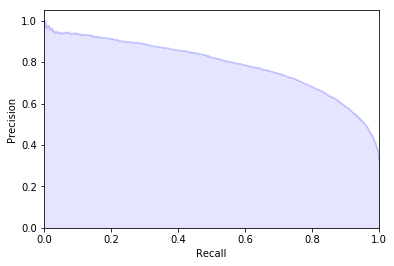

In [131]:
precision, recall, thresholds = metrics.precision_recall_curve(y_valid, rf_preds)
plt.step(recall, precision, color='b', alpha=0.1,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.1,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

# PART E - FEATURE ENGINEERING 
## Feature Importance

The models we have so far do average in terms of performance. They either perform as well as the baseline or worse. That is not helpeful as we want to use ML to make better predictions than naive approaches. For this reason we have to derive new features that can better identify key trends and information for the model to learn from. But how do we go about deciding what to derive and how? 

One (simple) way to approach this is to see the feature importance of a random forest which can tell us which features contribute the most in information gain to a random forest. From the top features we can deduce hypotheses that can be used to further develop new features.

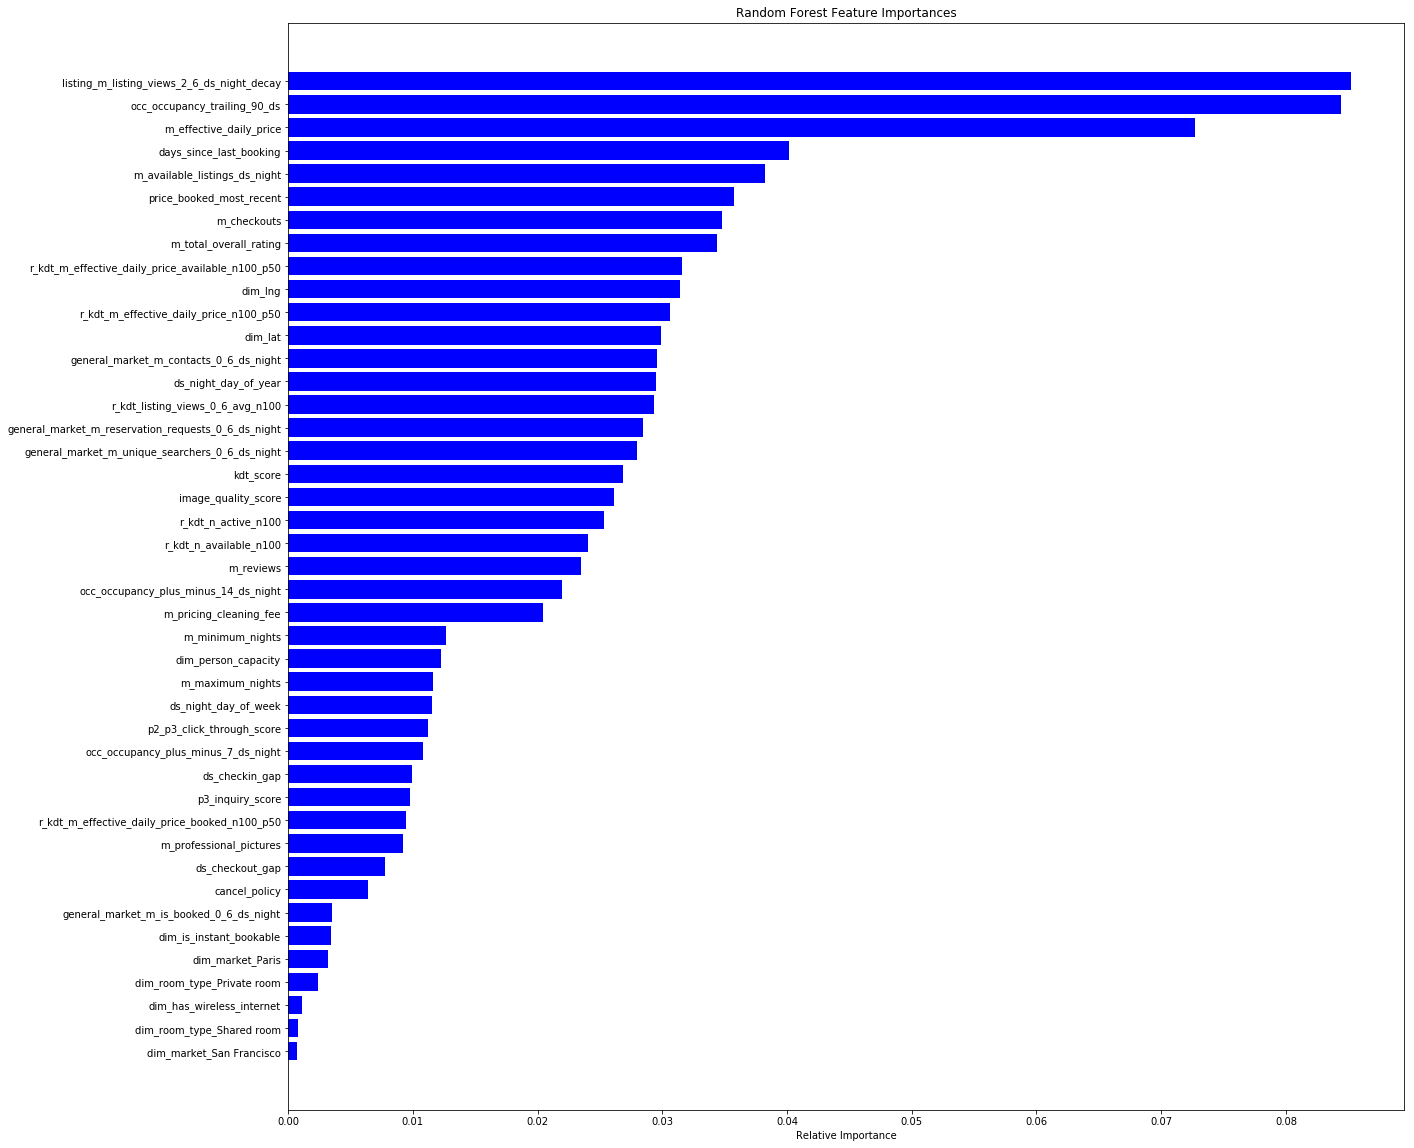

In [134]:
def plot_random_forest_importance(airbnb_data, rf_model):
    #features = iris['feature_names']
    feature_names = airbnb_data.iloc[:,5:].columns
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)

    plt.figure(figsize=(20,20))
    plt.title('Random Forest Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

plot_random_forest_importance(airbnb_data, rf_model)

# Hypotheses for Feature Engineering 
Looking at the feature importance rank a few things stand out:

1) that historical time based features that give a historical status of booking rates  (occ_occupancy_trailing_90_ds for example) are highly predictive. Essentially, what happened in the past is highly predictive of what will happen in the future. If we build new features then we want to capture the historical time based availability for a listing in the recent past.

2) The price of the listing is extremely predictive. this makes sense as the lower the price the less a customer has to spend. We should derive sharper measures of price relative to other listings

3) Features that measure demand implicitly like views and clicks can be very predictive as well. We should define better measures of listing and market demand

# Feature Engineering V1

Based on the above findings and hypotheses I create more features by either deriving historical averages or by transforming existing features into more useful measure distriubutions. These features are of the following types:

1) For each listing I go back a few periods for which we have data (between 1 and 8 prior periods) and get the historical booking status of the listing in that period. I use this historical availability to build new features based on whether a listing was available or not N periods in the past. I also look at the % change in booking averages etc;

2) I look at the price changes in the last few periods. These can be indicative of whether the price increased or decreased recently relative to the last period or last week etc

3) Similarly, I look at historically what was the volume of views that listing got in the recent past and not just today

4) Finally I do a few feature transformations on market and KDT features to ensure that we have KPIS for the market or KDT that make more sense vs just absolute numbers. 
For example: general_market_search_to_contact_rate  = searches/contacts. By transforming two given features into a KPI % we can better articulate the key trend a model should be looking at when measuring demand. That is a higher search to contact rate is indicative of greater demand. Similarly, by deriving KDT availability % and also price relative to KDT average we can create features that might help improve performance as they are transformed into more explicit relationships.

In [152]:
#simple moving average helper function to get historical averages for some features
def sma(data, n):
    return data.rolling(window=n).mean()

def create_new_features_listing(data):
    
    ##for each listing we go back in time and look if they were booked or not
    data['last_available_period_booking'] = data.groupby('id_listing_anon')['dim_is_requested'].apply(lambda x: x.shift(1))
    data['last_3_period_available_period_booking'] = data.groupby('id_listing_anon')['last_available_period_booking'].apply(sma,3)
    data['last_7_period_available_period_booking'] = data.groupby('id_listing_anon')['last_available_period_booking'].apply(sma,7)
    data['last_3_booked_perc_gain'] = data['last_3_period_available_period_booking']/data['last_7_period_available_period_booking']

    #historical price averages and time change indicators
    data['last_avail_period_effective_daily_price'] = data.groupby('id_listing_anon')['m_effective_daily_price'].apply(sma,1)    
    data['last_week_effective_daily_price'] = data.groupby('id_listing_anon')['last_avail_period_effective_daily_price'].apply(sma,6)    
    data['price_change_since_last_day'] = data['m_effective_daily_price']/data['last_avail_period_effective_daily_price']
    data['price_change_since_last_week_avg'] = data['m_effective_daily_price']/data['last_week_effective_daily_price']
 
    #historical listing views and listing rates of change
    data['listing_m_listing_views_2_6_ds_night_last_day'] = data.groupby('id_listing_anon')['listing_m_listing_views_2_6_ds_night_decay'].apply(sma,1)    
    data['listing_m_listing_views_2_6_ds_night_last_week'] = data.groupby('id_listing_anon')['listing_m_listing_views_2_6_ds_night_last_day'].apply(sma,6)  
    data['listing_views_day_change'] = data['listing_m_listing_views_2_6_ds_night_decay']/data['listing_m_listing_views_2_6_ds_night_last_day']
    data['listing_views_week_avg_change'] = data['listing_m_listing_views_2_6_ds_night_decay']/data['listing_m_listing_views_2_6_ds_night_last_week']
    
    #occupancy transformed to relative occupanices based on historical rates
    data['occupancy_7_days_change_relative_90_days'] = data['occ_occupancy_plus_minus_7_ds_night']/data['occ_occupancy_plus_minus_14_ds_night']
    data['occupancy_7_days_change_relative_14_days'] = data['occ_occupancy_plus_minus_7_ds_night']/data['occ_occupancy_trailing_90_ds']
    
    #listing click to inquiry score transformed to a KPI ratio
    data['click_to_inquiry_score_ratio'] = data['p3_inquiry_score']/data['p2_p3_click_through_score']
    
    #market KPI metrics to track the health and demand of the market itself
    data['general_market_search_to_contact_rate'] = data['general_market_m_contacts_0_6_ds_night']/data['general_market_m_unique_searchers_0_6_ds_night']
    data['general_market_contact_to_reservation_rate'] = data['general_market_m_reservation_requests_0_6_ds_night']/data['general_market_m_contacts_0_6_ds_night']
    data['general_market_reservation_to_booked_rate'] = data['general_market_m_is_booked_0_6_ds_night']/data['general_market_m_reservation_requests_0_6_ds_night']
    data['general_market_availability_rate'] = 1 - data['general_market_m_is_booked_0_6_ds_night']/(data['general_market_m_is_booked_0_6_ds_night'] + data['m_available_listings_ds_night'])

    #kdt metrics to understand demand and available for that kdt
    data['kdt_availability_percentage'] = data['r_kdt_n_available_n100']/data['r_kdt_n_active_n100']
    data['kdt_views_per_available_listing'] = data['r_kdt_listing_views_0_6_avg_n100']/data['r_kdt_n_active_n100']
    
    ##the price of the listing relative to other kdt listings
    data['price_relative_kdt_effective_daily_price'] = data['m_effective_daily_price']/data['r_kdt_m_effective_daily_price_n100_p50']
    data['price_relative_kdt_effective_daily_price_avail'] = data['m_effective_daily_price']/data['r_kdt_m_effective_daily_price_available_n100_p50']
    
    ## fill missing values with -1 and replace infinity with 0
    pd.options.mode.use_inf_as_na = True
    data = data.fillna(-1)
    data = data.replace('inf',0)
    #data = data.replace('-inf',0)
    #data[np.isneginf(data)] = 0

    return data

In [136]:
airbnb_derived_featrures_data = create_new_features_listing(airbnb_data)
airbnb_derived_featrures_data.head()

,dim_is_requested,ds_night,ds,id_listing_anon,id_user_anon,m_effective_daily_price,m_pricing_cleaning_fee,dim_lat,dim_lng,dim_person_capacity,dim_is_instant_bookable,m_checkouts,m_reviews,days_since_last_booking,cancel_policy,image_quality_score,m_total_overall_rating,m_professional_pictures,dim_has_wireless_internet,ds_night_day_of_week,ds_night_day_of_year,ds_checkin_gap,ds_checkout_gap,occ_occupancy_plus_minus_7_ds_night,occ_occupancy_plus_minus_14_ds_night,occ_occupancy_trailing_90_ds,m_minimum_nights,m_maximum_nights,price_booked_most_recent,p2_p3_click_through_score,p3_inquiry_score,listing_m_listing_views_2_6_ds_night_decay,general_market_m_unique_searchers_0_6_ds_night,general_market_m_contacts_0_6_ds_night,general_market_m_reservation_requests_0_6_ds_night,general_market_m_is_booked_0_6_ds_night,m_available_listings_ds_night,kdt_score,r_kdt_listing_views_0_6_avg_n100,r_kdt_n_active_n100,r_kdt_n_available_n100,r_kdt_m_effective_daily_price_n100_p50,r_kdt_m_effective_daily_price_available_n100_p50,r_kdt_m_effective_daily_price_booked_n100_p50,dim_market_Paris,dim_market_San Francisco,dim_room_type_Private room,dim_room_type_Shared room,last_available_period_booking,last_3_period_available_period_booking,last_7_period_available_period_booking,last_3_booked_perc_gain,last_avail_period_effective_daily_price,last_week_effective_daily_price,price_change_since_last_day,price_change_since_last_week_avg,listing_m_listing_views_2_6_ds_night_last_day,listing_m_listing_views_2_6_ds_night_last_week,listing_views_day_change,listing_views_week_avg_change,occupancy_7_days_change_relative_90_days,occupancy_7_days_change_relative_14_days,click_to_inquiry_score_ratio,general_market_search_to_contact_rate,general_market_contact_to_reservation_rate,general_market_reservation_to_booked_rate,general_market_availability_rate,kdt_availability_percentage,kdt_views_per_available_listing,price_relative_kdt_effective_daily_price,price_relative_kdt_effective_daily_price_avail
92617,0,2015-01-03,2014-12-04,00004783-f5e1-47cf-90bf-3daad76d1a09,251917ad-d2e8-467d-ace3-7e5699e16b89,308.737257,85.950775,48.87363,2.312445,3,0,0.0,0.0,-1.0,3,0.095232,0.0,0.0,1,6,3,7.0,7.0,-1.0,-1.0,0.0,1.0,1125.0,-1.0,-1.0,-1.0,0.000000,1673.857143,782.571429,144.142857,1.0,19373,0.863636,3.532653,124.0,61.0,166.718119,194.504472,-1.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,308.737257,-1.0,1.0,-1.0,0.000000,-1.0,-1.0,-1.0,1.0,-1.0,1.0,0.467526,0.184191,0.006938,0.999948,0.491935,0.028489,1.851852,1.587302
45319,0,2015-01-04,2014-12-05,00004783-f5e1-47cf-90bf-3daad76d1a09,251917ad-d2e8-467d-ace3-7e5699e16b89,308.386883,85.809113,48.87363,2.312445,3,0,0.0,0.0,-1.0,3,0.095232,0.0,0.0,1,0,4,7.0,7.0,-1.0,-1.0,0.0,1.0,1125.0,-1.0,-1.0,-1.0,0.000000,1288.428571,563.000000,102.714286,1.0,19654,0.727273,2.262585,123.0,61.0,160.361179,185.032130,-1.0,1,0,0,0,0.0,-1.0,-1.0,-1.0,308.386883,-1.0,1.0,-1.0,0.000000,-1.0,-1.0,-1.0,1.0,-1.0,1.0,0.436966,0.182441,0.009736,0.999949,0.495935,0.018395,1.923077,1.666667
4394,0,2015-01-07,2014-12-08,00004783-f5e1-47cf-90bf-3daad76d1a09,251917ad-d2e8-467d-ace3-7e5699e16b89,307.170580,85.542191,48.87363,2.312445,3,0,0.0,0.0,-1.0,3,0.095232,0.0,0.0,1,3,7,7.0,7.0,-1.0,-1.0,0.0,1.0,1125.0,-1.0,-1.0,-1.0,0.733333,1162.428571,440.285714,76.428571,1.0,20774,0.863636,1.938776,122.0,66.0,159.728702,165.872113,-1.0,1,0,0,0,0.0,-1.0,-1.0,-1.0,307.170580,-1.0,1.0,-1.0,0.733333,-1.0,1.0,-1.0,1.0,-1.0,1.0,0.378764,0.173589,0.013084,0.999952,0.540984,0.015892,1.923077,1.851852
177135,0,2015-01-13,2014-12-14,00004783-f5e1-47cf-90bf-3daad76d1a09,251917ad-d2e8-467d-ace3-7e5699e16b89,311.518725,85.266556,48.87363,2.312445,3,0,0.0,0.0,-1.0,3,0.095232,0.0,0.0,1,2,13,7.0,7.0,-1.0,-1.0,0.0,1.0,1125.0,-1.0,-1.0,-1.0,0.000000,1104.714286,418.142857,62.571429,1.0,21457,0.454545,2.367347,122.0,72.0,160.743662,186.911235,-1.0,1,0,0,0,0.0,0.0,-1.0,-1.0,311.518725,-1.0,1.0,-1.0,0.000000,-1.0,-1.0,-1.0,1.0,-1.0,1.0,0.378508,0.149641,0.015982,0.999953,0.590164,0.019404,1.937984,1.666667
4

In [137]:
x_train, x_valid, x_test, y_train, y_valid, y_test = train_valid_test_split(airbnb_derived_featrures_data, 0.3)

## Model Performance - With Feature Engineering Features

After feature engineering we can see that both the logistic and random forest models greatly improve in performance across accuracy, precision and recall. In fact the random forest now beats the baseline by around at least 4-15% across all metrics accuracy, precision, and recall.

In [141]:
print('Performance of Logistic Regression with derived features')
log_reg_model, log_preds = train_logistic_regression(x_train, y_train, x_valid, 0.1,'l2')
a, p, r = print_model_performance(log_preds, y_valid, 0.5, True)

Performance of Logistic Regression with derived features
The out of sample performance on validation data is:
The accuracy is 0.820
The precision is 0.750
The recall is 0.678


In [145]:
print('Performance of Random Forest with derived features')
rf_model, rf_preds = train_random_forest(x_train, y_train, x_valid, 200,2)
a,p,r = print_model_performance(rf_preds, y_valid, 0.5, True)

Performance of Random Forest with derived features
The out of sample performance on validation data is:
The accuracy is 0.854
The precision is 0.779
The recall is 0.773


In [400]:
print('For Comparison here is the baseline performance again')
print('The Baseline Accuracy is: ' + str("%.3f" % baseline_accuracy))
print('The Baseline Precision is: ' + str("%.3f" % baseline_precision))
print('The Baseline Recall is: ' + str("%.3f" % baseline_recall))

For Comparison here is the baseline performance again
The Baseline Accuracy is: 0.818
The Baseline Precision is: 0.742
The Baseline Recall is: 0.684


Looking at the feature importance we can see that the feature engineering definitely helped as the most dominant features now are all the historical and price based features we built based on the hypotheses. 

The most important feature now is if a listing was booked in the last avaialable period. Therefore, if a listing was booked in the past is most predictive if a listing will be booked again. Similarly, a recent price change can really affect a booking. Price increases can lead to impulse bookings. And Price decreases might convince users on the fence etc; These validates our hypotheses. 

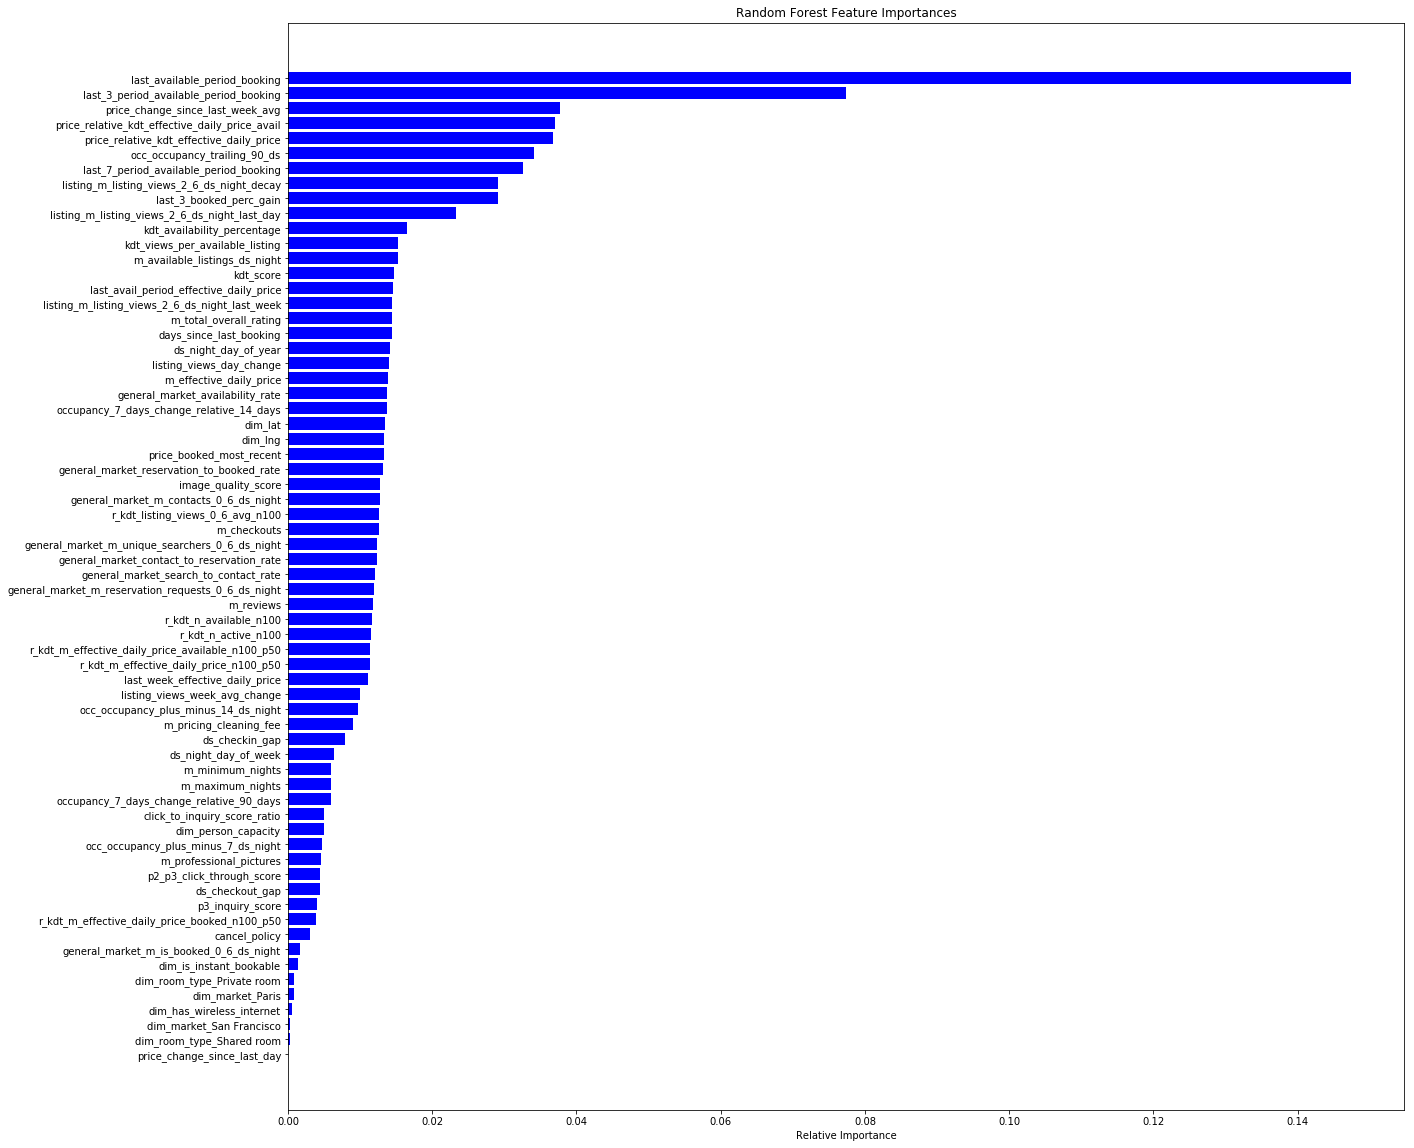

In [147]:
plot_random_forest_importance(airbnb_derived_featrures_data, rf_model)

# Feature Engineering V2

With that in mind lets revisit the features and create even more time based features to see if we can extract more performance from these same set of ideas.

In [148]:
def create_new_features_listing(data, drop_missing):
    
    ##for each listing we go back in time
    data['last_available_period_booking'] = data.groupby('id_listing_anon')['dim_is_requested'].apply(lambda x: x.shift(1))
    data['lag_2_available_period_booking'] = data.groupby('id_listing_anon')['dim_is_requested'].apply(lambda x: x.shift(2))
    data['lag_3_available_period_booking'] = data.groupby('id_listing_anon')['dim_is_requested'].apply(lambda x: x.shift(3))
    data['lag_4_available_period_booking'] = data.groupby('id_listing_anon')['dim_is_requested'].apply(lambda x: x.shift(4))
    data['lag_5_available_period_booking'] = data.groupby('id_listing_anon')['dim_is_requested'].apply(lambda x: x.shift(5))
    data['lag_6_available_period_booking'] = data.groupby('id_listing_anon')['dim_is_requested'].apply(lambda x: x.shift(6))
    data['lag_7_available_period_booking'] = data.groupby('id_listing_anon')['dim_is_requested'].apply(lambda x: x.shift(7))

    data['last_3_period_available_period_booking'] = data.groupby('id_listing_anon')['last_available_period_booking'].apply(sma,3)
    data['last_7_period_available_period_booking'] = data.groupby('id_listing_anon')['last_available_period_booking'].apply(sma,7)

    #historical listing views and listing time change indicators
    data['listing_m_listing_views_2_6_ds_night_last_day'] = data.groupby('id_listing_anon')['listing_m_listing_views_2_6_ds_night_decay'].apply(sma,1)    
    data['listing_m_listing_views_2_6_ds_night_last_week'] = data.groupby('id_listing_anon')['listing_m_listing_views_2_6_ds_night_last_day'].apply(sma,6)  
    
    #historical price averages and time change indicators
    data['last_avail_period_effective_daily_price'] = data.groupby('id_listing_anon')['m_effective_daily_price'].apply(sma,1)    
    data['last_week_effective_daily_price'] = data.groupby('id_listing_anon')['last_avail_period_effective_daily_price'].apply(sma,6)    
    
    if drop_missing == True:
        data = data.dropna(axis=0, inplace = False)

    ##percentage changes for the above
    data['listing_views_day_change'] = data['listing_m_listing_views_2_6_ds_night_decay']/data['listing_m_listing_views_2_6_ds_night_last_day']
    data['listing_views_week_avg_change'] = data['listing_m_listing_views_2_6_ds_night_decay']/data['listing_m_listing_views_2_6_ds_night_last_week']
  
    data['price_change_since_last_day'] = data['m_effective_daily_price']/data['last_avail_period_effective_daily_price']
    data['price_change_since_last_week_avg'] = data['m_effective_daily_price']/data['last_week_effective_daily_price']
 
    data['last_day_booked_perc_gain_7_days'] = data['last_available_period_booking']/data['last_7_period_available_period_booking']
    data['last_day_booked_perc_gain_7_days'] = data['last_available_period_booking']/data['last_3_period_available_period_booking']
    data['last_3_days_booked_perc_gain_7_days'] = data['last_3_period_available_period_booking']/data['last_7_period_available_period_booking']

    #occupancy transformed to relative occupanices based on historical rates
    data['occupancy_7_days_change_relative_90_days'] = data['occ_occupancy_plus_minus_7_ds_night']/data['occ_occupancy_plus_minus_14_ds_night']
    data['occupancy_7_days_change_relative_14_days'] = data['occ_occupancy_plus_minus_7_ds_night']/data['occ_occupancy_trailing_90_ds']
    
    #listing click to inquiry score transformed to a KPI ratio
    data['click_to_inquiry_score_ratio'] = data['p3_inquiry_score']/data['p2_p3_click_through_score']
    
    #market KPI metrics to track the health and demand of the market itself
    data['general_market_search_to_contact_rate'] = data['general_market_m_contacts_0_6_ds_night']/data['general_market_m_unique_searchers_0_6_ds_night']
    data['general_market_contact_to_reservation_rate'] = data['general_market_m_reservation_requests_0_6_ds_night']/data['general_market_m_contacts_0_6_ds_night']
    data['general_market_reservation_to_booked_rate'] = data['general_market_m_is_booked_0_6_ds_night']/data['general_market_m_reservation_requests_0_6_ds_night']
    data['general_market_availability_rate'] = 1 - data['general_market_m_is_booked_0_6_ds_night']/(data['general_market_m_is_booked_0_6_ds_night'] + data['m_available_listings_ds_night'])

    #kdt metrics to understand demand and available for that kdt
    data['kdt_availability_percentage'] = data['r_kdt_n_available_n100']/data['r_kdt_n_active_n100']
    data['kdt_views_per_available_listing'] = data['r_kdt_listing_views_0_6_avg_n100']/data['r_kdt_n_active_n100']
    
    ##the price of the listing relative to other kdt listings
    data['price_relative_kdt_effective_daily_price'] = data['m_effective_daily_price']/data['r_kdt_m_effective_daily_price_n100_p50']
    data['price_relative_kdt_effective_daily_price_avail'] = data['m_effective_daily_price']/data['r_kdt_m_effective_daily_price_available_n100_p50']
    
    pd.options.mode.use_inf_as_na = True
    data = data.fillna(-1)
    data = data.replace('inf',0)
    #data = data.replace('-inf',0)
    #data[np.isneginf(data)] = 0

    return data

In [149]:
airbnb_derived_features_data_v2 = create_new_features_listing(airbnb_data, False)

In [150]:
print('Performance of Logistic Regression with derived features V2')
x_train, x_valid, x_test, y_train, y_valid, y_test = train_valid_test_split(airbnb_derived_features_data_v2, 0.3)
log_reg_model, log_preds = train_logistic_regression(x_train, y_train, x_valid, 0.1, 'l2')
a,p,r = print_model_performance(log_preds, y_valid, 0.5, True)

Performance of Logistic Regression with derived features V2
The out of sample performance on validation data is:
The accuracy is 0.824
The precision is 0.752
The recall is 0.691


In [151]:
print('Performance of Random Forest with derived features V2')
rf_model, rf_preds = train_random_forest(x_train, y_train, x_valid, 200,2)
a,p,r = print_model_performance(rf_preds, y_valid, 0.5, True)

Performance of Random Forest with derived features V2
The out of sample performance on validation data is:
The accuracy is 0.852
The precision is 0.774
The recall is 0.773


## Feature Engineering V2 Evaluation
After creating more features based on time we see that the random forest doesn't improve much in performance although the log regression does see a slight improvement in recall (69.1% vs 67.8%). It seems like we have extracted a lot of information from historical availability and trying to transform and derive more will lead to marginal if any improvements. It's time to focus on other ideas.

# Feature Engineering V3 
## Creating User Based Features
One of the ways to improve feature engineering would be to aggregate at the user level instead of the listing. Users can have multiple listings. The hypothesis here is that good users will have high in demand listings everywhere. So maybe if we aggregatate at the user level we can get better measures of listing demand and likelihood to book based on who the user is. It is not feasible to use the user id as a feature as there are 7K+users and many will have sparse data points which can lead to overfitting but we can average out booking trends for a user instead

In [153]:
def create_host_features(airbnb_data_2):
    #this function groups by user instead of listing
    airbnb_data_2['user_booked'] = airbnb_data_2.groupby(['id_user_anon','ds'])['dim_is_requested'].transform('sum')
    airbnb_data_2['user_listings'] = airbnb_data_2.groupby(['id_user_anon','ds'])['dim_is_requested'].transform('size')
    #airbnb_data_2['user_average_rating'] = airbnb_data_2.groupby(['id_user_anon','ds'])['m_total_overall_rating'].transform('mean')
    #airbnb_data_2['user_average_price'] = airbnb_data_2.groupby(['id_user_anon','ds'])['m_effective_daily_price'].transform('mean')
    airbnb_data_2['user_booked_percentage'] = airbnb_data_2['user_booked']/airbnb_data_2['user_listings']

    airbnb_data_2['user_booked_percentage_previous_period'] = airbnb_data_2.groupby('id_user_anon')['user_booked_percentage'].apply(lambda x: x.shift(1))
    airbnb_data_2['user_booked_percentage_previous_period_7_days'] = airbnb_data_2.groupby('id_listing_anon')['user_booked_percentage_previous_period'].apply(sma,6)
    airbnb_data_2.drop(['user_booked','user_booked_percentage'], inplace=True, axis=1)
    
    airbnb_data_2 = airbnb_data_2.fillna(-1)
    
    return airbnb_data_2

airbnb_derived_features_data_v3 = create_host_features(airbnb_derived_features_data_v2)

In [155]:
print('Performance of Logistic Regression with derived features V3')
x_train, x_valid, x_test, y_train, y_valid, y_test = train_valid_test_split(airbnb_derived_features_data_v3, 0.3)
log_reg_model, log_preds = train_logistic_regression(x_train, y_train, x_valid, 0.1, 'l2')
a,p,r = print_model_performance(log_preds, y_valid, 0.5, True)

Performance of Logistic Regression with derived features V3
The out of sample performance on validation data is:
The accuracy is 0.826
The precision is 0.754
The recall is 0.695


In [156]:
print('Performance of Random Forest with derived features V3')
rf_model, rf_preds = train_random_forest(x_train, y_train, x_valid, 200,2)
a,p,r = print_model_performance(rf_preds, y_valid, 0.5, True)

Performance of Random Forest with derived features V3
The out of sample performance on validation data is:
The accuracy is 0.851
The precision is 0.775
The recall is 0.771


But from the above we can see that building user based features didn't add any improvement to model performance. Accuracy remains similar for both models.

# Feature Engineering V4 (Final Feature Version)
There is one problem with our historical features we created earlier. Time Gaps in the data. As noted earlier, days for which a listing was not already available were removed from the dataset when given. 

But these days could have been days that were already booked. As such these days could have been very predictive as they indicate a listing has been booked and therefore migth be booked again in the future. If we remove these days we lose that information. I circumvented this problem by inferring the days that were booked.

I first created a base table that was the cross product of each day and listing id. Then I merged that with our data and if a match was not found for a listing and a date combination in our data, I flagged that listing and date combination as 1 implying that it was already booked. Then I created the same historical flags like before. (Dates after ds were discarded as they were meaningless).

Now we have a true time series, where we can say for every day whether the last N days were booked (or unavialble) or not.

In [157]:
import itertools
def create_listing_date_base(data):
    unique_dates = data['ds'].unique()
    unique_listings = data['id_listing_anon'].unique()

    base_table = np.array(list(itertools.product(unique_listings,unique_dates)))
    base_table = pd.DataFrame(base_table, columns = ['id_listing_anon','ds'])
    base_table = base_table.sort_values(by = ['id_listing_anon','ds'])
    base_table = base_table.merge(data[['dim_is_requested', 'id_listing_anon','ds']]
                                  , on =['id_listing_anon','ds'], how='left')
    
    #I assume that if a record is missing for a day then that listing is either unavailable or booked
    #Hence it is flagged as 1.
    base_table = base_table.fillna(1)
    return base_table

In [158]:
base_listing_date = create_listing_date_base(airbnb_derived_features_data_v3)
base_listing_date['previous_day_unavailablity'] = base_listing_date.groupby('id_listing_anon')['dim_is_requested'].apply(lambda x: x.shift(1))
base_listing_date['previous_3_day_avg_unavailability'] = base_listing_date.groupby('id_listing_anon')['previous_day_unavailablity'].apply(sma,3)   
base_listing_date['previous_7_day_avg_unavailability'] = base_listing_date.groupby('id_listing_anon')['previous_day_unavailablity'].apply(sma,7)
airbnb_derived_features_data_v4 = airbnb_derived_features_data_v3.merge(base_listing_date, on =['id_listing_anon','ds'], how='left')
airbnb_derived_features_data_v4 = airbnb_derived_features_data_v4.fillna(-1)
airbnb_derived_features_data_v4.drop('dim_is_requested_y', axis=1, inplace=True)
airbnb_derived_features_data_v4 = airbnb_derived_features_data_v4.rename(columns={'dim_is_requested_x': 'dim_is_requested'})

In [181]:
print('Performance of Logistic Regression with derived features V4')
x_train, x_valid, x_test, y_train, y_valid, y_test = train_valid_test_split(airbnb_derived_features_data_v4, 0.3)
log_reg_model, log_preds = train_logistic_regression(x_train, y_train, x_valid, 0.1, 'l2')
a,p,r = print_model_performance(log_preds, y_valid, 0.5, True)

Performance of Logistic Regression with derived features V4
The out of sample performance on validation data is:
The accuracy is 0.833
The precision is 0.760
The recall is 0.721


In [182]:
print('Performance of Random Forest with derived features V4')
rf_model, rf_preds = train_random_forest(x_train, y_train, x_valid, 200,2)
a,p,r = print_model_performance(rf_preds, y_valid, 0.5, True)

Performance of Random Forest with derived features V4
The out of sample performance on validation data is:
The accuracy is 0.852
The precision is 0.771
The recall is 0.783


## Final Feature Evaluation 

From the above it can be seen that fixing the time gap issue and creating true last N day availability metrics helped improve the performance of the Logistic Regression Model significantly. Accuracy jumped from 0.826 to 0.833 and Recall especially saw a big increase from 0.695 to 0.721. The random forest however performed as well as before without a major improvement. Therefore these features helped the Log regression model but didn't help the Random Forest so much. Irrespective we will use this as the final feature data set for our model evalution.

### An Important Note on Feature Selection from an Engineering Standpoint

The final set of features include lots of useless highly correlated features that are essentially measuring the same thing. Due to time constraints, I am unable to do feature selection here but if time permitted I would have removed highly correlated and unimportant features from the dataset. For log regression, this can lead to improvements in performance although for Random Forests it tends to matter less.

Irrespective of performance gain, it is generally better to have a simple model (if performance is not compromised) because when models go into production and have to be refreshed daily, having tons of features that add nothing to the model can make it difficult to maintain data pipelines and ensure data integrity. Assuming two models with similar accuracy but one with less feature complexity and space, the more simple model should be productionized.

# PART F - ADVANCED ALGORITHMIC IMPROVEMENTS

Witrh feature engineering finalized it is now time to turn attention again to the algorithm. So far we have been looking at only log regression and random forersts. But more powerful methods like:

1) Neural Networks
2) Ensembling Techniques (Stacking or Blending)

can also be utilized to help improve model performance from an algorithmic standpoint. In the following section I will now try to see if model accuracy (and precision and recall) can be improved by using even more advanced techniques

## a) Neural Networks

In [186]:
def train_neural_network(x_train, y_train, input_len, e, batch, valid_split):
    # define the architecture for the simple feed forward network
    model = Sequential()
    model.add(Dense(50, input_dim=input_len, kernel_initializer="uniform", activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(25, kernel_initializer="uniform", activation="sigmoid"))
    model.add(Dropout(0.25))
    model.add(Dense(1))
    model.add(Activation("sigmoid"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
    model.fit(x_train, y_train, epochs=e, batch_size=batch, verbose=1, validation_split=valid_split)
    return model

Lets first start off with a simple neural network with random parameters. This neural network has 3 hidden layers with different neurons. It also uses neuron dropout to help achieve better generalization. The Relu and Sigmoid activation functions are used as they are especially good for classification problems.

In [187]:
nn_model = train_neural_network(x_train, y_train, x_train.shape[1], 25, 128, 0.3)

In [189]:
nn_pred = nn_model.predict(x_valid)
print('The Performance of the Neural Network using the Final Set of Features:')
a,p,r = print_model_performance(nn_pred, y_valid, 0.5, True)

The Performance of the Neural Network using the Final Set of Features:
The out of sample performance on validation data is:
The accuracy is 0.852
The precision is 0.762
The recall is 0.799


Looking above, just with random hyperparameters we already have a neural network that does as well as the random forest in accuracy and actually beats all models in Recall showing a big jump up to almost 80%! Let's see if we can do better with another set of parameters.

In [429]:
#retraining the neural net with a few different set of parameters
def train_neural_network(x_train, y_train, input_len, e, batch, lr):
    # define the architecture for the simple feed forward network
    model = Sequential()
    model.add(Dense(128, input_dim=input_len, kernel_initializer="uniform", activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(64, kernel_initializer="uniform", activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(32, kernel_initializer="uniform", activation="sigmoid"))
    model.add(Dense(1))
    model.add(Activation("sigmoid"))
    optimizer = Adam(lr=lr)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])
    model.fit(x_train, y_train, epochs=e, batch_size=batch, verbose=0, validation_data = (x_valid, y_valid))
    return model

nn_model = train_neural_network(x_train, y_train, x_train.shape[1], 25, 128, 0.001)
nn_pred = nn_model.predict(x_valid)
print('The Performance of the new Neural Network using the Final Set of Features:')
a,p,r = print_model_performance(nn_pred, y_valid, 0.5, True)

The Performance of the new Neural Network using the Final Set of Features:
The out of sample performance on Test data is:
The accuracy is 0.852
The precision is 0.760
The recall is 0.808


Oh Wow! Just by tweaking the parameters a little we saw ana lmost 1% increase in Recall (going up to 80.8%). And even though Precision and Accuracy is the same it shows that just changing parameters slightly in a neural network can lead to changes in overall model performance.

### Neural Network Hyper Parameter Tuning

To get the best set of parameters we would have to do an exhaustive search across the parameter spaces using many advanced algorithms proposed in academic literature. Unforuntely there are lots of parameter combinations and due to time constraints I will just do a small search across a few of the more important parameters namely instead of trying to implement more advanced academic approaches:

1) Batch size - the number of training samples a model sees at each step
2) Learnning Rate - in Stochastic gradient descent this is the rate at which weights are updated by the gradient to minimze the error
3) Hidden Neurons - The number of neurons in each of our layer (or weights)

In [403]:
def neural_network_grid_search(x_train, y_train, input_len, e, batch, lr, neurons, seed):
    # define the architecture for the simple feed forward network
    model = Sequential()
    model.add(Dense(neurons, input_dim=input_len, kernel_initializer="uniform", activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(int(neurons/2), kernel_initializer="uniform", activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(int(neurons/3), kernel_initializer="uniform", activation="sigmoid"))
    model.add(Dense(1))
    model.add(Activation("sigmoid"))
    optimizer = Adam(lr=lr)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=4)
    history = History()
    
    nn_model = model.fit(x_train, y_train
              , epochs=e
              , batch_size=batch
              , verbose=0
              , validation_data = (x_valid, y_valid)
              , callbacks=[early_stopping, history]
              , shuffle = True)
    
    return nn_model, nn_model.history 

In [406]:
#tuning the neural net with a few choices of parameters
batch_sizes = [64,128,256,512]
learning_rates = [0.0001, 0.001, 0.01, 0.1]
neurons = [128,64,50,32]
seed = 125758

grid_search_results = pd.DataFrame(columns=['Model_Number','Batch Size','Learning Rate','Hidden Neurons Max'
                                            ,'Train_Acc','Valid_Acc'])
i = 0
for batch in batch_sizes:
    for lr in learning_rates:
        for n in neurons:
            nn_model, model_hist = neural_network_grid_search(x_train, y_train, x_train.shape[1], 2, batch, lr, n, seed)
            
            val_loss = model_hist["val_loss"][-1]
            val_acc = model_hist["val_acc"][-1]
            loss = model_hist["loss"][-1]
            acc = model_hist["acc"][-1]

            grid_search_results.loc[i] = 0
            grid_search_results.iloc[i,0] = i
            grid_search_results.iloc[i,1] = batch
            grid_search_results.iloc[i,2] = lr
            grid_search_results.iloc[i,3] = n
            #grid_search_results.iloc[i,4] = loss
            grid_search_results.iloc[i,4] = acc
            #grid_search_results.iloc[i,6] = val_loss
            grid_search_results.iloc[i,5] = val_acc
            
            print('Models Trained= '+ str(i), end=',')
            i = i + 1

Models Trained= 0,Models Trained= 1,Models Trained= 2,Models Trained= 3,Models Trained= 4,Models Trained= 5,Models Trained= 6,Models Trained= 7,Models Trained= 8,Models Trained= 9,Models Trained= 10,Models Trained= 11,Models Trained= 12,Models Trained= 13,Models Trained= 14,Models Trained= 15,Models Trained= 16,Models Trained= 17,Models Trained= 18,Models Trained= 19,Models Trained= 20,Models Trained= 21,Models Trained= 22,Models Trained= 23,Models Trained= 24,Models Trained= 25,Models Trained= 26,Models Trained= 27,Models Trained= 28,Models Trained= 29,Models Trained= 30,Models Trained= 31,Models Trained= 32,Models Trained= 33,Models Trained= 34,Models Trained= 35,Models Trained= 36,Models Trained= 37,Models Trained= 38,Models Trained= 39,Models Trained= 40,Models Trained= 41,Models Trained= 42,Models Trained= 43,Models Trained= 44,Models Trained= 45,Models Trained= 46,Models Trained= 47,Models Trained= 48,Models Trained= 49,Models Trained= 50,Models Trained= 51,Models Trained= 52,Mod

The results for the grid search are below sorted by validation accuracy

In [408]:
grid_search_results.set_index('Model_Number')
grid_search_results.to_csv('grid_search_results.csv', index = False)
grid_search_results = grid_search_results.sort_values(by=['Valid_Acc'], ascending=False)
print(grid_search_results)

    Model_Number  Batch Size  Learning Rate  Hidden Neurons Max  Train_Acc  \
20            20         128         0.0010                 128   0.843514   
4              4          64         0.0010                 128   0.842579   
36            36         256         0.0010                 128   0.842513   
56            56         512         0.0100                 128   0.839564   
25            25         128         0.0100                  64   0.839542   
5              5          64         0.0010                  64   0.841490   
27            27         128         0.0100                  32   0.835085   
26            26         128         0.0100                  50   0.836758   
43            43         256         0.0100                  32   0.837649   
21            21         128         0.0010                  64   0.838760   
52            52         512         0.0010                 128   0.840092   
7              7          64         0.0010                  32 

From the above grid search results we can see that the choice of parameters can greatly influence Neural Network perforamnce. However even the best neural network did not have better validation accuracy than the neural network I had before so I will continue to use my previous neural network architecture and parameters. 

A few notes on the parameters:

    1) Generally a big learning rate like 0.1 does poorly in accuracy. Small learning rates do better.
    2) The best models tend to have more complex architectures (neurons = 128 in first layer)
   
Therefore if I had more time, I would have delved deeper into these two parameters and especially the neurons number as those can be very valuable in extracting more accuracy out of the model.

# b) Stacking

Stacking is a powerful technique where we split the train data into smaller random chunks. Then train a model on another small subset of data and use the parameters from that model to make predictions on another completely disjoint subset of data. By stacking predictions from 1 model to another subset of data we can train using predictions as features which can help us achieve better performance. The following functions do stacking where train is split in two parts. Part A trains a logistic regression and then Part B uses predictions from the log regression model in Part A to train a random foresrt on Part B 

In [196]:
def train_stacked_split(data, stack_split_perc, split_perc):
    
    standard_scaler = preprocessing.StandardScaler(with_mean=True, with_std=True)
        
    train_valid, test = train_test_split(data, test_size=split_perc, random_state = 45)
    train, valid = train_test_split(train_valid, test_size=split_perc, random_state = 45)    
    stack_one, stack_two = train_test_split(train, test_size=stack_split_perc, random_state = 45)    
    
    x_stack_one = stack_one.iloc[:,5:]
    x_stack_two = stack_two.iloc[:,5:]
    x_valid = valid.iloc[:,5:]
    x_test = test.iloc[:,5:]
    
    x_stack_one = standard_scaler.fit_transform(x_stack_one)
    x_stack_two = standard_scaler.fit_transform(x_stack_two)
    x_valid = standard_scaler.fit_transform(x_valid)
    x_test = standard_scaler.fit_transform(x_test)
    
    y_stack_one = stack_one.loc[:,'dim_is_requested']
    y_stack_two = stack_two.loc[:,'dim_is_requested']
    y_valid = valid.loc[:,'dim_is_requested']
    y_test = test.loc[:,'dim_is_requested']
        
    return x_valid, x_test, x_stack_one, x_stack_two, y_stack_one, y_stack_two, y_valid, y_test

In [205]:
x_valid, x_test, x_stack_one, x_stack_two, y_stack_one, y_stack_two, y_valid, y_test = train_stacked_split(airbnb_derived_features_data_v4, 0.5,0.3)
stack_one_model, stack_train_preds = train_logistic_regression(x_stack_one, y_stack_one, x_stack_two, 0.1,'l2')
#stack_one_model, stack_train_preds = train_neural_network(x_stack_one, y_stack_one, x_stack_one.shape[1], 25, 128, 0.001)
stack_valid_preds = stack_one_model.predict_proba(x_valid)
stack_test_preds = stack_one_model.predict_proba(x_test)
x_stack_two =  np.column_stack([x_stack_two, stack_train_preds])
x_valid =  np.column_stack([x_valid, stack_valid_preds[:,1]])
x_test =  np.column_stack([x_test, stack_test_preds[:,1]])
stacked_rf_model, stacked_preds = train_random_forest(x_stack_two, y_stack_two, x_valid, 200,2)

However, It seems like stacking doesn't improve model performance here. The first model is a log regression and then a random forest uses its predictions to make predictions using a second subset of data. But the stacked ensemble doesn't seem to do better than an individual random forest.

In [209]:
print('Performance of the Stacked Log Regressionm + Random Forest Model')
a,p,r = print_model_performance(stacked_preds, y_valid, 0.5, True)

Performance of the Stacked Log Regressionm + Random Forest Model
The out of sample performance on validation data is:
The accuracy is 0.853
The precision is 0.773
The recall is 0.785


# c) Blending 

Finally I will try blending in the predictions of different models to see if it helps with performance. Blending is simply taking a weighted average of each of the indivudual model predictions. So for example we can combine the log regression, random forest, and neural network predictions in a weighted linear combination so that some model predictions are weighted more heavily than others. Blending works when we have many uncorrelated (or low correlated) models. The general idea being that 1 model might be good at detecting particular trends while another might be good at detecting other trends so their combined ensemble might lead to overall improvements that neither of the two models individually could achieve.

In this experiment I will just try a couple of combinations but theoretically we can try all different combinations to see which one performs best.

In [ ]:
nn_pred = nn_model.predict(x_valid)
rf_model, rf_preds = train_random_forest(x_train, y_train, x_valid, 200,2)
log_reg_model, log_preds = train_logistic_regression(x_train, y_train, x_valid, 0.1, 'l2')

In [238]:
print('Blending the Neural Net and Random Forest in 60/40% ratio')
blended_preds = 0.6*nn_pred[:,0] + 0.4*np.array(rf_preds)
a,p,r = print_model_performance(blended_preds, y_valid, 0.5, True)

The out of sample performance on validation data is:
The accuracy is 0.856
The precision is 0.767
The recall is 0.809


In [246]:
## All 3 - Neural Network + Random Forest + Logisitic Regression
print('Blending the Neural Net and Random Forestand Logistic Regression in 50/30/20% ratio')
blended_preds = 0.5*nn_pred[:,0] + 0.3*np.array(rf_preds) + 0.2*np.array(log_preds)
a,p,r = print_model_performance(blended_preds, y_valid, 0.5, True)

Blending the Neural Net and Random Forestand Logistic Regression in 60/40% ratio
The out of sample performance on validation data is:
The accuracy is 0.856
The precision is 0.771
The recall is 0.801


From the above we can see that when we blend in all 3 models we actually get a model that is slightly better than any of the ones individually. In this case we were able to get marginally higher accuracy but also precision although recall dropped very slightly. It should be added that the differences are very small and it remains to be seen if these will actually translate into measurable lift when tested on hidden truly out of sample Test data.

# PART G -  EVALUATION ON TEST DATA

All told, our final model does much better than the baseline seeing a 15% improvement in Recall and a 4% improvement in Precision and Accuracy. But so far all feature engineering, training and tuning and ensembling has been done on a validation data set split. Now that we have a model ready we are ready to see how goood the model actually performs when tested against completely new hidden data. For this reason, the final ensemble model which is the best model will be evaluated on new test data that was originally held out prior to training. This test data comprises 30% of all the data that was kept after data cleaning randomly sampled.

In [432]:
## need to modify function slightly so it returns us a test dataframe too.
def train_valid_test_split(data, split_perc):
    
    #train_valid = data[data['ds'] <= date_cutoff]
    #test = data[data['ds'] > date_cutoff] 
    
    standard_scaler = preprocessing.StandardScaler(with_mean=True, with_std=True)
    
    train_valid, test = train_test_split(data, test_size=split_perc, random_state = 45)
    train, valid = train_test_split(train_valid, test_size=split_perc, random_state = 45)
    
    x_train = train.iloc[:,5:]
    x_valid = valid.iloc[:,5:]
    x_test = test.iloc[:,5:]
    
    x_train = standard_scaler.fit_transform(x_train)
    x_valid = standard_scaler.fit_transform(x_valid)
    x_test = standard_scaler.fit_transform(x_test)
    
    y_train = train.loc[:,'dim_is_requested']
    y_valid = valid.loc[:,'dim_is_requested']
    y_test = test.loc[:,'dim_is_requested']
        
    return x_train, x_valid, x_test, y_train, y_valid, y_test, test

##changing print to test data
def print_model_performance(preds, true, cutoff, verbose):
    preds[preds >= cutoff] = 1
    preds[preds < cutoff] = 0
    acc, precision, recall = get_model_performance(preds, true)
    
    if verbose == True:
        print('The out of sample performance on Test data is:')
        print('The accuracy is ' + str("%.3f" % acc))
        print('The precision is ' + str("%.3f" % precision))
        print('The recall is ' + str("%.3f" % recall))
    
    return acc, precision, recall

In [433]:
## All 3 - Neural Network + Random Forest + Logisitic Regression
x_train, x_valid, x_test, y_train, y_valid, y_test, test = train_valid_test_split(airbnb_derived_features_data_v4, 0.3)
nn_pred = nn_model.predict(x_test)
rf_model, rf_preds = train_random_forest(x_train, y_train, x_test, 200,2)
log_reg_model, log_preds = train_logistic_regression(x_train, y_train, x_test, 0.1, 'l2')

print('Blending the Neural Net and Random Forestand Logistic Regression in 50/30/20% ratio')
test_blended_preds = 0.5*nn_pred[:,0] + 0.3*np.array(rf_preds) + 0.2*np.array(log_preds)
test['model_predictions'] = test_blended_preds
a,p,r = print_model_performance(test_blended_preds, y_test, 0.5, True)

Blending the Neural Net and Random Forestand Logistic Regression in 50/30/20% ratio
The out of sample performance on Test data is:
The accuracy is 0.855
The precision is 0.782
The recall is 0.780


/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [281]:
test.to_csv('test_final.csv')

The final blended model performs similarly on the test set indiccating no major overfitting of data (although recall does drop slightly). Either way this model is still at least 4% better in accuracy and precision than the baseline we built in the beginning. It is also much more better in recall by at least 15%.

## Model Performance on Sub Cohorts

To better understand model performance I break up model performance over different cohorts to see if the model performs better in some cohorts vs others

In [374]:
def accuracy(x):
    if (x['dim_is_requested'] == 1 and x['model_predictions'] >=0.5) or (x['dim_is_requested'] == 0 and x['model_predictions'] <0.5):
        return 1
    else:
        return 0

cohort_data = test.assign(correct_pred=test.apply(accuracy, axis=1))

In [362]:
def plot_cohort_accuracy_continuous(cohort_data, feature):
    cohorts = cohort_data.groupby([feature])['correct_pred'].sum()/cohort_data.groupby([feature])['correct_pred'].size()
    plt.plot(cohorts)
    plt.xlabel(feature)
    plt.ylabel('accuracy')
    plt.title('Accuracy of Model when brekaing down by: ' + str(feature))
    plt.show()

It seems like (ignore outliers cohorts with only a few points taking accuracy up to 1):
1) non holiday seasoons like spring and fall are the toughest for the model to predict.
2) the more the capacity the harder it gets to predict correctly
3) listings that just had a booking (months since Last booking = 0) are harder to predict

These insights give us clues as to where the model can be improved. In particular the part about recent booked listings being more difficult to predict correctly is insightful because it can force us to look for more data points for listings that just had a booking

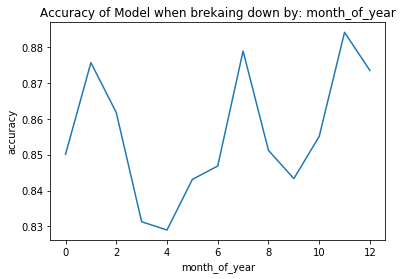

In [324]:
plot_cohort_accuracy_continuous(cohort_data, 'month_of_year')

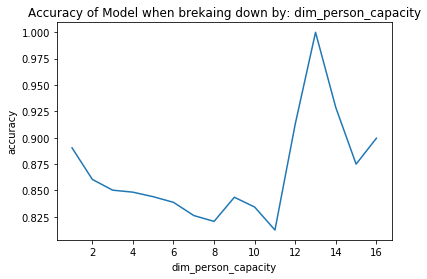

In [326]:
plot_cohort_accuracy_continuous(cohort_data, 'dim_person_capacity')

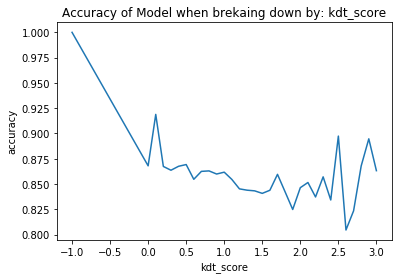

In [329]:
cohort_data['kdt_score'] = np.around(cohort_data['kdt_score'],1)
plot_cohort_accuracy_continuous(cohort_data, 'kdt_score')

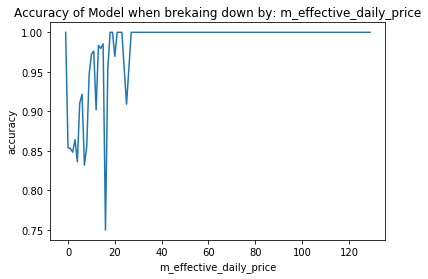

In [375]:
cohort_data['m_effective_daily_price'] = np.floor(cohort_data['m_effective_daily_price']/100)
plot_cohort_accuracy_continuous(cohort_data, 'm_effective_daily_price')

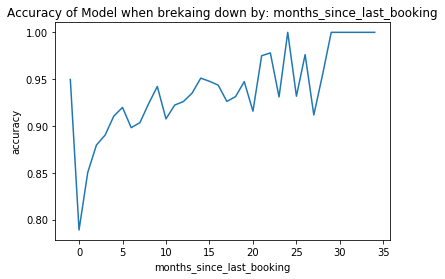

In [340]:
cohort_data['months_since_last_booking'] = np.floor(cohort_data['days_since_last_booking']/30)
plot_cohort_accuracy_continuous(cohort_data, 'months_since_last_booking')

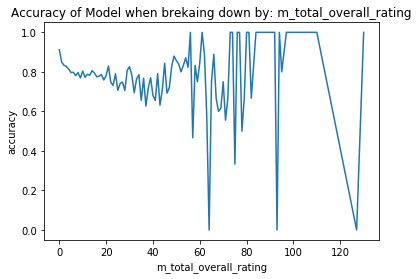

In [345]:
cohort_data['m_total_overall_rating'] = np.floor(cohort_data['m_total_overall_rating']/10)
plot_cohort_accuracy_continuous(cohort_data, 'm_total_overall_rating')

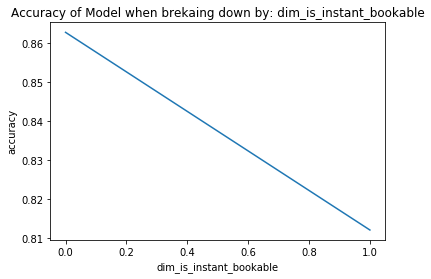

In [365]:
plot_cohort_accuracy_continuous(cohort_data, 'dim_is_instant_bookable')

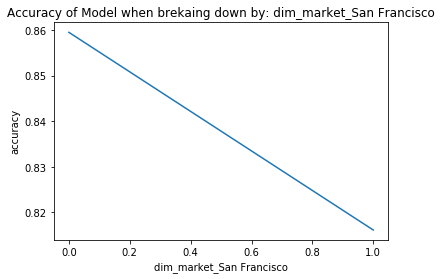

In [368]:
plot_cohort_accuracy_continuous(cohort_data, 'dim_market_San Francisco')

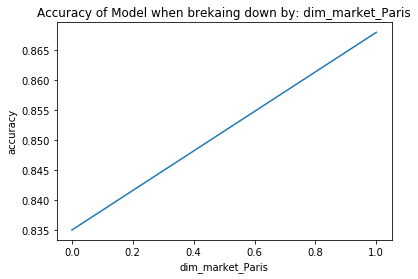

In [401]:
plot_cohort_accuracy_continuous(cohort_data, 'dim_market_Paris')

# PART H - Conclusion and Recommendations
## Summary

In this project, I used Airbnb Data to predict whether a listing on a given day would be booked 30 days into the future or not. The features initially provided did a poor job beating a simple baseline that just looked at whether a listing was booked or not in the last available period. Simple Logistic Regression with Regularization and a Random Forest were trained to help make predictions and the evaluation metric used was Accuracy along with Precision and Recall. Train, Validation and Test sets were randomly created from the data for evaluation purpose with 50% train, 20% validation and 30% test data.

However, with feature enginering I devised a series of features that indicated historical booking status of a listing in the recent past, and a listing's historical average price and demand in the area. These features helped improve the model performance by at least 4% in accuracy and precision and approximately 15% in Recall easily beating the baseline.

In addition, more advanced algorithms and ensembling techniques like neural nets and blending/stacking weres used which might have improved performance by a slight margin as well.

Finally model was evaluated on out of seen test data after all parameter tuning and feature engineering was done. The final performance on out of sample test data was very similar to validation accuracy (approximately 85%) indicating that overfitting on validation data had not occured and the model could indeed be generalized and put in production.

The results of all the models are again summarized below for reference.

## Product Recommendations for Using Model

If we have a good model that can predict whether a listing will be booked 30 days in advance or not then we can leverage this information proactively to make product enhancements that  help drive and improve the user experience for both guests and hosts. Here are some specific ways new product features could be launched using the model predictions:


### To improve the User Experience
1) `Introduce Urgency Messaging on Listing Cards and Apartment Pages:` If a listing is expected to be booked then we can have a special message on the listing card on the browse or listing page that basically tells the user that this listing is about to be booked. This will create urgency for users who are on the fence about booking

2) `Introduce Urgency Messaging through Email/Push`: Same as above but this time if a listing is expected to be booked then we send an email and push notification to users who saw that listing for the time period in question informing them about the listing about to be booked so they can hurry up. For example" 'Hurry up! The apartment you saw in NYC now has a 50% more chance of being booked by tonight!'

3) `Improve Ranking of Listings on Homes Page`: We can improve the ranking algorithm of homes shown on the main marketplace home page by boosting those listings that are very likely to be booked. This basically ensures that users find homes that are most in demand vs those homes which people are not showing an interest essentially serving as a boosting multiplier to get already in demand homes off the market as quickly as possible so more room for the less active homes can be made.

### To improve the Host Experience
1) `Encourage Hosts to Reduce Prices to Drive Bookings`: If a listing is expected to not be booked then hosts can be informed about changing prices to encourage people to book. If we recall from the analysis on feature importance, price changes were highly predictive of whether a listing will be booked.  

2) `Encourage Hosts to Increase Availability/Re List their Apartments/Homes`: If a marketplace is showing strong increase in bookings likely to be made in the next month using the model predictions, then we can esentially email hosts that are inactive or have their apartments unavailable to increase availability and list their apartments online as they are more likely to be booked. This leads to more bookings for the host. 

## Other Modeling Ideas using this Dataset

There are some other ways this dataset can also be used for modeling purposes

1) `Predicting click through or inquiry score`: If we recall click through score (p2_p3_click_through_score/inquiry score) had a huge number of missing data. Almost 70% of the data was missing. One way we can overcome this problem is essentially predicting click through score for those listings we are missing data on using the listings for which we do have click through score. It won't be perfect but it is a much better substitute than hacking at missing values using averages or random values and might even lead to model performance improvements. We can do the same for image quality score. 

2) `Predicting days until next bookings`: Instead of predicting whether a listing will be booked 30 days in to the future we can just predict the days until next booking. This has the added benefit of not necessarily constraning us to a hard time cut off limit. For example a listing might get booked 21 days or 40 days in the future and knowing days until next booking can help better with planning.

3) `Predict available percentage for a KDT Cluster`: Instead of predicting for each listing we can use this data to predict availability percentage for a KDT cluster. Doing so can help us inform expected demand for different clusters of listings. We might also have better accuracy as KDTs are possibly less granular and the average nature of the cluster might make it more easy to predict accounting due to less  noise and variance compared to individual listings